# **SUMMA BOT**

**Project Members**
- Member1 = mtalha2s
- Member2 = ssohai2s

## Libraries

In [1]:
import heapq
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import string
import sklearn

from collections import OrderedDict
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.stem import WordNetLemmatizer
from rouge import Rouge 
from termcolor import colored
from tika import parser 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


Bad key "text.kerning_factor" on line 4 in
/home/sorox23/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Download Requirements

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/sorox23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sorox23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sorox23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sorox23/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading pre-trained model for Glove, W2Vec, Fasttext

### Glove pre-trained model

In [3]:
def glove_word_vectors():
  '''
  Reads and stores the embeddings from the pre-trained glove model.
  '''
  word_embeddings = {}
  f = open('glove.6B.300d.txt', encoding='utf-8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs
  f.close()
  return word_embeddings

glove_word_embbeddings = glove_word_vectors()

### W2Vec pre-trained model

Link for the W2Vec English wiki embeddings:
https://drive.google.com/file/d/1F9pndKlaMCRWp9awvQsoC5XLeRANclnV/view

In [4]:
def word2vec():
  '''
  Reads and stores the embeddings from the pre-trained W2vec english wiki model.
  '''
  word_embeddings = {}
  f = open('en_wiki_word2vec_300.txt', encoding='utf-8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs
  f.close()
  return word_embeddings

w2vec_word_embbeddings = word2vec()

### Fasttext pre-trained model

Link for the Fasttext English wiki embeddings:
https://drive.google.com/file/d/1U3rYodGoo6BRzuOA53WBY9OY_QaWZcey/view

In [5]:
def fasttext_vec():
  '''
  Reads and stores the embeddings from the pre-trained Fasttext english wiki model.
  '''
  word_embeddings = {}
  f = open('en_wiki_fasttext_300.txt', encoding='utf-8')
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_embeddings[word] = coefs
  f.close()
  return word_embeddings

fasttext_embbeddings = fasttext_vec()

## PDF TO TEXT


In [17]:
def pdf_to_text_tika(file_path:str)->str:
  '''
  Converts pdf to string document.
  '''
  parsed = parser.from_file(file_path)
  content = parsed["content"]
  document = content.replace("\n", " ")
  return document

class PdfCleaner():
  '''
  Preprocesses a give pdf document given in string format by removing the abstract
  
  '''
  def __init__(self, document:str):
    self.original_document = document
    self.processed_document = document
    self.abstract = None
    self.references = None
    self.acknowledgement = None
    self.related_work = None
    self.conclusion = None
    self.citations = None
    self.urls = None

  def print_original_document(self):
    '''
    Prints original document.
    '''
    print(self.original_document)


  def print_processed_document(self):
    '''
    Prints processed document.
    '''
    print(self.processed_document)
    
  def abstract_removal(self):
    '''
    Removes abstract from the document.
    '''
    self.abstract = re.compile(r'(Abstract—.+?)(I\.)').findall(self.original_document)[0][0]
    initial_text = re.compile(r'(^.+)(?=Abstract—)').findall(self.original_document)[0]
    self.processed_document= self.processed_document.replace(initial_text, '')
    self.processed_document= self.processed_document.replace(self.abstract, '')    
    self.abstract = self.abstract.replace('Abstract', '')
    self.abstract = self.abstract.replace('—', '')

    keywords_list = ["Index", "Keywords"]

    for word in keywords_list:
      if word in self.abstract:
        self.abstract = self.abstract.split(word, 1)
        self.abstract = self.abstract[0].strip()
        break

  def reference_remover(self):
    '''
    Removes references from the document.
    '''
    self.references  = re.compile(r'(REFERENCES)(.*)').findall(self.original_document)
    if self.references:
      self.references = self.references[0][0] + self.references[0][1]
      self.processed_document= self.processed_document.replace(self.references, '')

  def acknowledgement_remover(self):
    '''
    Removes acknowledgement from the document.
    '''
    self.acknowledgement  = re.compile(r'(ACKNOWLEDGMENT|ACKNOWLEDGEMENT)(.*)(?=REFERENCES)').findall(self.original_document)
    if self.acknowledgement:
      self.acknowledgement = self.acknowledgement[0][0] + self.acknowledgement[0][1]
      self.processed_document= self.processed_document.replace(self.acknowledgement, '')

  def related_work_remover(self):
    '''
    Removes related work from the document.
    '''
    def romanToInt(s):
      """
      :type s: str
      :rtype: int
      """
      roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
      i = 0
      num = 0
      while i < len(s):
          if i+1<len(s) and s[i:i+2] in roman:
            num+=roman[s[i:i+2]]
            i+=2
          else:
            #print(i)
            num+=roman[s[i]]
            i+=1
      return num

    def write_roman(num):
      '''
      Converts normal number to roman number .
      '''

      roman = OrderedDict()
      roman[1000] = "M"
      roman[900] = "CM"
      roman[500] = "D"
      roman[400] = "CD"
      roman[100] = "C"
      roman[90] = "XC"
      roman[50] = "L"
      roman[40] = "XL"
      roman[10] = "X"
      roman[9] = "IX"
      roman[5] = "V"
      roman[4] = "IV"
      roman[1] = "I"

      def roman_num(num):
          for r in roman.keys():
              x, y = divmod(num, r)
              yield roman[r] * x
              num -= (r * x)
              if num <= 0:
                  break

      return "".join([a for a in roman_num(num)])
    
    check_related_work = re.compile(r'(RELATED WORK)').findall(self.original_document)
    if check_related_work:
      related_work_roman = re.compile(r'([\s\S]{5})(RELATED WORK)').findall(self.original_document)
      related_work_roman = [word.replace(".", "") for word in related_work_roman[0]]
      prev_num = romanToInt(related_work_roman[0].strip())
      next_roman = write_roman(prev_num + 1)

      self.related_work  = re.compile(r'(RELATED WORK)(.*)' + re.escape(next_roman) + r'\. [A-Z]{3,}').findall(self.original_document)
      self.related_work = self.related_work[0][0] + self.related_work[0][1]
      self.processed_document= self.processed_document.replace(self.related_work, '')

  def conclusion_remover(self):
    '''
    Removes conclusion from the document.
    '''
    self.conclusion  = re.compile(r'(CONCLUSION)(.*)(?=(REFERENCES|ACKNOWLEDGMENT|ACKNOWLEDGEMENT))').findall(self.original_document)
    if self.conclusion:
      self.conclusion = self.conclusion[0][0] + self.conclusion[0][1]
      self.processed_document= self.processed_document.replace(self.conclusion, '')
      self.conclusion = self.conclusion.replace('CONCLUSION', '').strip()

  def citations_remover(self):
    '''
    Removes citation from the document.
    '''
    self.citations = re.compile(r'\[[\d]+\]').findall(self.original_document)
    for citation in self.citations:
      self.processed_document= self.processed_document.replace(citation, '')

  def url_remover(self):
    '''
    Removes citation from the document.
    '''
    self.urls = re.compile(r'http\S+').findall(self.original_document)
    if self.urls:
      for url in self.urls:
        self.processed_document= self.processed_document.replace(url, '')

  def extra_space_remover(self):
    '''
    Removes more than 1 space from the document.
    '''
    self.processed_document = re.sub(r'\s+', ' ', self.processed_document)

  def pdf_to_text_driver(self):
    '''
    Runs all pre processing modules.
    '''
    self.abstract_removal()
    self.related_work_remover()
    self.conclusion_remover()
    self.acknowledgement_remover()
    self.reference_remover()
    self.citations_remover()
    self.url_remover()
    self.extra_space_remover()
    # self.print_original_document()
    # self.print_processed_document()
    return self.processed_document

## PRE-PROCESSING TEXT

In [18]:
class PreProcessor():
  '''
  Tokenizes a given document in sentences. Removes punctuations, small sentences,
  and stopwords. Lemmatizes the words in the sentences, as well as converts the
  sentences into lowercase.
  '''
  def __init__(self, document):
    
    self.sentences : list
    self.tokens : list
    self.min_words_in_sent = 5
    self.document = document
    self.processed_doc = None    

  def print_sentences(self):
    '''
    Prints the sentences.
    '''
    print(self.sentences)

  def document_to_sentences(self):
    '''
    Tokenizes the document into sentences using the nltk library.
    '''
    self.sentences = nltk.tokenize.sent_tokenize(self.document)

  def remove_punctuations(self):
    '''
    Removes punctuations from the sentences via regex.
    Removes everything that is not a word or a numeral.
    '''
    punc_free = []
    for words in self.sentences:
      punc_free.append(re.sub(r'[^a-zA-Z0-9]', ' ', words))
    self.sentences = punc_free

  def lower_case(self):
    '''
    Converts the sentences to lower case.
    '''
    lower = []
    for words in self.sentences:
      lower.append(words.lower())
    self.sentences = lower

  def remove_small_sentences(self):
    '''
    Removes sentences that have too less words in them.
    '''
    remove_small_sent = []
    for sentence in self.sentences:
      if len(sentence) >= self.min_words_in_sent:
        remove_small_sent.append(sentence)
    self.sentences = remove_small_sent

  def remove_stop_words(self):
    '''
    Removes the stop words based on the nltk english stop word collection.
    '''
    removed_stopped_word = []
    stop_words = nltk.corpus.stopwords.words('english')
    for sentence in self.sentences:
      tokens = nltk.tokenize.word_tokenize(sentence)
      non_stop_word_sentence = []
      for word in tokens:
        if word in stop_words:
          continue
        else:
          non_stop_word_sentence.append(word)
      non_stop_word_sentence = ' '.join(non_stop_word_sentence)
      removed_stopped_word.append(non_stop_word_sentence)
    self.sentences = removed_stopped_word

  def get_wordnet_pos(self, treebank_tag):
    '''
    It determines whether the word is verb, noun, adjective, or adverb.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
      
  def get_pos_tag(self, word):
    '''
    Get POS tag from the word net.
    '''
    word_tag = pos_tag([word])
    return self.get_wordnet_pos(word_tag[0][1])

  def text_lemmatization(self):
    '''
    Lemmatizes the sentences
    '''
    lemmatized_sentences = []
    lemmatizer = WordNetLemmatizer()
    for sentence in self.sentences:
      tokens = word_tokenize(sentence)
      lemmatized_sentence = []
      for w in tokens:
        lemmatized_sentence.append(lemmatizer.lemmatize(word=w,pos=self.get_pos_tag(w)))

      lemmatized_sentence = ' '.join(lemmatized_sentence)
      lemmatized_sentences.append(lemmatized_sentence)

    self.sentences = lemmatized_sentences

  def preprocessor_driver(self):
    '''
    Driver function for the preprocessor.
    '''
    self.document_to_sentences()
    self.lower_case()
    self.remove_punctuations()
    self.remove_small_sentences()
    self.remove_stop_words()
    self.text_lemmatization()
    return self.sentences

## SUMMA BOT GLOVE

In [19]:
class SummaBotGlove():
  '''
  Text summarizer using the glove embeddings.
  '''
  def __init__(self, cleaned_sentences, number_of_summary_sentences:int, embedding):
    self.word_embeddings = embedding
    self.cleaned_sentences = cleaned_sentences
    self.number_of_summary_sentences = number_of_summary_sentences
    self.ranked_sentences = None
    self.vector_sentences = None
    self.similarity_matrices = None
    self.summary = None

  def vectors_sentences(self):
    '''
    Takes a sentences, acquires vectors of the words, averages over the word
    vectors to create a sentence vector.
    '''
    sentence_vectors = []
    for i in self.cleaned_sentences:
      if len(i) != 0:
        v = sum([self.word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
      else:
        v = np.zeros((300,))
      sentence_vectors.append(v)
    self.vector_sentences = sentence_vectors
  
  def similarity_matrix(self):
    '''
    Creates a similarity matrix for each sentence against every other sentence.
    '''
    similarity_mat = np.zeros([len(self.vector_sentences), len(self.vector_sentences)])
    for i in range(len(self.vector_sentences)):
      for j in range(len(self.vector_sentences)):
        if i != j:
          similarity_mat[i][j] = sklearn.metrics.pairwise.cosine_similarity(self.vector_sentences[i].reshape(1,300), self.vector_sentences[j].reshape(1,300))[0,0]
    self.similarity_matrices = similarity_mat

  def graph_ranking(self):
    '''
    Takes the similarity matrix and transforms it into a graph, where the node
    represents the sentences and the edges represents the similarity between those
    sentences. Finally, using the pagerank algorithm the sentences are ranked.
    '''
    nx_graph = nx.from_numpy_array(self.similarity_matrices)
    scores = nx.pagerank(nx_graph)
    self.ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(self.cleaned_sentences)), reverse=True)
    
  def extracted_summary(self):
    '''
    Prints the excerpted summary.
    '''
    print('\n','SUMMABOT GLOVE','\n')
    for i in range(self.number_of_summary_sentences):
      print(self.ranked_sentences[i][1])

  def summabot_driver(self):
    '''
    Driver function for SUMMABOT Glove.
    '''
    self.vectors_sentences()
    self.similarity_matrix()
    self.graph_ranking()
    # self.extracted_summary()
    return self.ranked_sentences

## SUMMA BOT FREQUENCY

In [20]:
class SummaBotFrequency():
  '''
  Text summarizer using the frequency of the words.
  '''
  def __init__(self, cleaned_sentences, number_of_summary_sentences:int):
    self.cleaned_sentences = cleaned_sentences
    self.number_of_summary_sentences = number_of_summary_sentences

  def word_frequencies(self):
    '''
    Stores the most frequent words provided they are not stop words.
    '''
    stop_words = nltk.corpus.stopwords.words('english')
    self.word_frequencies  = {}
    for sent in self.cleaned_sentences:
      for word in nltk.tokenize.word_tokenize(sent):
          if word not in stop_words:
              if word not in self.word_frequencies .keys():
                  self.word_frequencies [word] = 1
              else:
                  self.word_frequencies [word] += 1
    maximum_frequency = max(self.word_frequencies.values())

    for word in self.word_frequencies.keys():
      self.word_frequencies[word] = (self.word_frequencies[word]/maximum_frequency)
  
  def sentences_score(self):
    '''
    Scores the sentences based on the amount of highly frequent words occurring.
    '''
    self.sentence_scores = {}
    for sent in self.cleaned_sentences:
        for word in nltk.tokenize.word_tokenize(sent):
            if word in self.word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in self.sentence_scores.keys():
                        self.sentence_scores[sent] = self.word_frequencies[word]
                    else:
                        self.sentence_scores[sent] += self.word_frequencies[word]
    
  def extracted_summary(self):
    '''
    Prints the excerpted summary.
    '''
    self.summary = heapq.nlargest(self.number_of_summary_sentences, self.sentence_scores, key=self.sentence_scores.get)
    # print('\n','SUMMABOT Frequency','\n')
    # for sentences in self.summary:
    #   print(sentence

  def summabot_driver(self):
    '''
    Driver function for SUMMABOT Frequency.
    '''
    self.word_frequencies()
    self.sentences_score()
    self.extracted_summary()
    return self.summary

## SUMMA BOT W2VEC

In [21]:
class SummaBotW2Vec():
  '''
  Text summarizer using the W2Vec embeddings.
  '''
  def __init__(self, cleaned_sentences, number_of_summary_sentences:int, embedding): 
    self.word_embeddings = embedding
    self.cleaned_sentences = cleaned_sentences
    self.number_of_summary_sentences = number_of_summary_sentences
    self.ranked_sentences = None
    self.vector_sentences = None
    self.similarity_matrices = None
    self.summary = None

  def vectors_sentences(self):
    '''
    Takes a sentences, acquires vectors of the words, averages over the word
    vectors to create a sentence vector.
    '''
    sentence_vectors = []
    for i in self.cleaned_sentences:
      if len(i) != 0:
        v = sum([self.word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
      else:
        v = np.zeros((300,))
      sentence_vectors.append(v)
    self.vector_sentences = sentence_vectors
  
  def similarity_matrix(self):
    '''
    Creates a similarity matrix for each sentence against every other sentence.
    '''
    similarity_mat = np.zeros([len(self.vector_sentences), len(self.vector_sentences)])
    for i in range(len(self.vector_sentences)):
      for j in range(len(self.vector_sentences)):
        if i != j:
          similarity_mat[i][j] = sklearn.metrics.pairwise.cosine_similarity(self.vector_sentences[i].reshape(1,300), self.vector_sentences[j].reshape(1,300))[0,0]
    self.similarity_matrices = similarity_mat

  def graph_ranking(self):
    '''
    Takes the similarity matrix and transforms it into a graph, where the node
    represents the sentences and the edges represents the similarity between those
    sentences. Finally, using the pagerank algorithm the sentences are ranked.
    '''
    nx_graph = nx.from_numpy_array(self.similarity_matrices)
    scores = nx.pagerank(nx_graph)
    self.ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(self.cleaned_sentences)), reverse=True)
    
  def extracted_summary(self):
    '''
    Prints the excerpted summary.
    '''
    print('\n','SUMMABOT W2Vec','\n')
    for i in range(self.number_of_summary_sentences):
      print(self.ranked_sentences[i][1])

  def summabot_driver(self):
    '''
    Driver function for SUMMABOT W2Vec.
    '''
    self.vectors_sentences()
    self.similarity_matrix()
    self.graph_ranking()
    # self.extracted_summary()
    return self.ranked_sentences

## SUMMA BOT FASTTEXT

In [22]:
class SummaBotFasttext():
  '''
  Text summarizer using the Fasttext embeddings.
  '''
  def __init__(self, cleaned_sentences, number_of_summary_sentences:int, embedding):
    
    self.word_embeddings = embedding
    self.cleaned_sentences = cleaned_sentences
    self.number_of_summary_sentences = number_of_summary_sentences
    self.ranked_sentences = None
    self.vector_sentences = None
    self.similarity_matrices = None
    self.summary = None

  def vectors_sentences(self):
    '''
    Takes a sentences, acquires vectors of the words, averages over the word
    vectors to create a sentence vector.
    '''
    sentence_vectors = []
    for i in self.cleaned_sentences:
      if len(i) != 0:
        v = sum([self.word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
      else:
        v = np.zeros((300,))
      sentence_vectors.append(v)
    self.vector_sentences = sentence_vectors
  
  def similarity_matrix(self):
    '''
    Creates a similarity matrix for each sentence against every other sentence.
    '''
    similarity_mat = np.zeros([len(self.vector_sentences), len(self.vector_sentences)])
    for i in range(len(self.vector_sentences)):
      for j in range(len(self.vector_sentences)):
        if i != j:
          similarity_mat[i][j] = sklearn.metrics.pairwise.cosine_similarity(self.vector_sentences[i].reshape(1,300), self.vector_sentences[j].reshape(1,300))[0,0]
    self.similarity_matrices = similarity_mat

  def graph_ranking(self):
    '''
    Takes the similarity matrix and transforms it into a graph, where the node
    represents the sentences and the edges represents the similarity between those
    sentences. Finally, using the pagerank algorithm the sentences are ranked.
    '''
    nx_graph = nx.from_numpy_array(self.similarity_matrices)
    scores = nx.pagerank(nx_graph)
    self.ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(self.cleaned_sentences)), reverse=True)
    
  def extracted_summary(self):
    '''
    Prints the excerpted summary.
    '''
    print('\n','SUMMABOT Fasttext','\n')
    for i in range(self.number_of_summary_sentences):
      print(self.ranked_sentences[i][1])

  def summabot_driver(self):
    '''
    Driver function for SUMMABOT Fasttext.
    '''
    self.vectors_sentences()
    self.similarity_matrix()
    self.graph_ranking()
    # self.extracted_summary()
    return self.ranked_sentences

## SUMMA SENTENCE RECONSTRUCTOR

In [23]:
def extract_ranked_sentences(ranked_sentences, num_of_sentences):
  '''
  Determines top ranked vectors
  '''
  extracted_summary_sentences = []
  for i in range(len(ranked_sentences)):
    if i == num_of_sentences:
      break
    extracted_summary_sentences.append(ranked_sentences[i][1])
  
  return extracted_summary_sentences

def get_unprocessed_sentence_vectors(cleaned_doc):
  '''
  Get sentence vectors using GloVe for clean but unprocessed sentences
  '''
  unprocessed_sentences = nltk.tokenize.sent_tokenize(cleaned_doc)
  Summa_1 = SummaBotGlove(unprocessed_sentences, 30, glove_word_embbeddings)
  Summa_1.vectors_sentences()
  unprocessed_sentence_vectors = Summa_1.vector_sentences

  return unprocessed_sentences, unprocessed_sentence_vectors

def get_ranked_sentence_vectors(top_ranked_sentences):
  '''
  Get sentence vectors of ranked sentences
  '''
  ranked_sentence_vectors = []
  for i in range(len(top_ranked_sentences)):
    tokenized_ranked_sentence = nltk.tokenize.sent_tokenize(top_ranked_sentences[i])
    Summa_1 = SummaBotGlove(tokenized_ranked_sentence, 30, glove_word_embbeddings)
    Summa_1.vectors_sentences()
    ranked_sentence_vectors.append(Summa_1.vector_sentences)

  return ranked_sentence_vectors


def sentence_builder(ranked_sentence_vectors, unprocessed_sentence_vectors, unprocessed_sentences, top_ranked_sentences):
  '''
  Re-builds the sentences based on similarity of the given sentences with the original document.
  '''
  proper_summarized_sentences = []
  docB = unprocessed_sentence_vectors

  # Loop through the ranked sentence vectors
  for k in range(len(ranked_sentence_vectors)):
    
    # Determine the similarity matrix for each ranked sentence vector against the unprocessed sentences
    docA = ranked_sentence_vectors[k]
    similarity_matrix = np.zeros([len(docA), len(docB)])
    for i in range(len(docA)):
      for j in range(len(docB)):
        if i != j:
          similarity_matrix[i][j] = sklearn.metrics.pairwise.cosine_similarity(docA[i].reshape(1,300), docB[j].reshape(1,300))[0,0]

    # Since the matrix has just one row, convert it to list
    similarity_list = similarity_matrix[0].tolist()

    # Determine the top ten similarities
    top_ten_similarities = sorted(zip(similarity_list), reverse=True)[:10]

    # Determine the top ten indices for the top ten similarities
    index_list = []
    for i in range(len(top_ten_similarities)):
      index_list.append(similarity_list.index(top_ten_similarities[i][0]))
    
    # Determine the processed sentences for the top ten most similar sentences
    top_ten_processed_sentences = []
    for i in range(len(index_list)):
      preprocessing_1 = PreProcessor(unprocessed_sentences[index_list[i]])
      top_ten_processed_sentences.append(preprocessing_1.preprocessor_driver()[0])

    # Check the ranked sentence against the processed sentence and store the corresponding unprocessed sentence
    match_found = False
    for i in range(len(top_ten_processed_sentences)):
      if (top_ten_processed_sentences[i] == top_ranked_sentences[k]):
        proper_summarized_sentences.append(unprocessed_sentences[index_list[i]])
        match_found = True
        break

    # If match not found store the sentence with the first index
    if match_found == False:
      proper_summarized_sentences.append(unprocessed_sentences[index_list[0]])

  return proper_summarized_sentences

def print_reconstructed_summary(proper_summarized_sentences):
  '''
  Prints the reconstructed sentences.
  '''
  for i in range(len(proper_summarized_sentences)):
    print(proper_summarized_sentences[i])

def sentence_builder_driver(summary, cleaned_doc):
  '''
  Reconstructs the sentences based on their similarity to the original text.
  '''
  unprocessed_sentences, unprocessed_sentence_vectors = get_unprocessed_sentence_vectors(cleaned_doc)
  ranked_sentence_vectors = get_ranked_sentence_vectors(summary)
  proper_summarized_sentences = sentence_builder(ranked_sentence_vectors, unprocessed_sentence_vectors, unprocessed_sentences, summary)
  print_reconstructed_summary(proper_summarized_sentences)

## SUMMA BOT EVALUATION

In [24]:
def summarizer_evaluation_bleu(tokenized_summary, tokenized_paper_summary):
  '''
  Calculates the corpus Bleu score. 
  '''
  ground_truth = []
  hypothesis = []

  smoothing = nltk.translate.bleu_score.SmoothingFunction()
  
  for real_sentences in tokenized_paper_summary:
    ground_truth.append(nltk.tokenize.word_tokenize(''.join(real_sentences)))
  for ranked_sentences in tokenized_summary:
    hypothesis.append(nltk.tokenize.word_tokenize(''.join(ranked_sentences)))
  while len(hypothesis) > len(ground_truth):
    del hypothesis[-1]
  while len(hypothesis) < len(ground_truth):
    del ground_truth[-1]
  score = corpus_bleu(ground_truth, hypothesis ,smoothing_function = smoothing.method7)
  return score

def summarizer_evaluation_rouge(tokenized_summary, tokenized_paper_summary):
  '''
  Calculates the recall score of both texts for unigram. 
  '''
  rouge = Rouge()
  scores = rouge.get_scores(' '.join(tokenized_summary), ' '.join(tokenized_paper_summary))
  recall = scores[0]
  return recall['rouge-1']

## SUMMABOT VISUALIZATION

In [25]:
def score_visualization(bleu_scores, rogue_recall_scores, rogue_precision_scores, rogue_fscores):
  '''
  Bar chart for the scores of each document.
  '''
  x = np.arange(4)
  width = 0.1
  
  plt.figure(figsize=(16,8), dpi=100)
  plt.bar(x-0.2, bleu_scores, width, color='red', edgecolor ='w', alpha=0.8)
  plt.bar(x-0.1, rogue_recall_scores, width, color='navy', edgecolor ='w', alpha=0.8)
  plt.bar(x, rogue_precision_scores, width, color='yellow', edgecolor ='w', alpha=0.8)
  plt.bar(x+0.1, rogue_fscores, width, color='orange', edgecolor ='w', alpha=0.8)
  plt.title('Visualization of Scores', fontsize = 18)
  plt.xticks(x, ['Summa Frequency', 'Summa Glove', 'Summa Word2Vec', 'Summa FastText'], fontsize = 12)
  plt.xlabel("Summa Models",fontsize = 14)
  plt.ylabel("Scores",fontsize = 14)
  plt.legend(["Bleu Score", "Rogue Recall Score", "Rogue Precision Score", "Rogue F-Score"], loc='best', fontsize = 10)
  plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.2)
  plt.grid(b=True, which='minor', color='k', linestyle='-', alpha=0.15)
  plt.minorticks_on()
  plt.show()

def word_cloud(text):
  '''
  Generates word cloud.
  '''
  plt.figure(figsize=(16,8))
  wordcloud = WordCloud(width=800, height=400, max_font_size=90, max_words=500, background_color="white").generate(text)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show(wordcloud)

## SUMMA BOT DRIVER

In [26]:
def SummaBotDriver(file_path, num_summary_sentences=10):
  '''
  Driver function for Summa Bot.
  '''
  document = pdf_to_text_tika(file_path)

  cleaned_pdf = PdfCleaner(document)
  cleaned_doc = cleaned_pdf.pdf_to_text_driver() 
  
  # Preprocess Cleaned Research Paper
  preprocessing = PreProcessor(cleaned_doc)
  tokeninzed_sentences = preprocessing.preprocessor_driver()
  
  # Frequency ranked sentences
  Summa_freq = SummaBotFrequency(tokeninzed_sentences, num_summary_sentences)
  summary_frequency = Summa_freq.summabot_driver()
  # Glove ranked sentences
  Summa_glove = SummaBotGlove(tokeninzed_sentences, num_summary_sentences, glove_word_embbeddings)
  summary_glove = Summa_glove.summabot_driver()
  # W2Vec ranked sentences
  Summa_w2vec = SummaBotW2Vec(tokeninzed_sentences, num_summary_sentences, w2vec_word_embbeddings)
  summary_w2vec = Summa_w2vec.summabot_driver()
  # Fasttext ranked sentences
  Summa_fasttext= SummaBotFasttext(tokeninzed_sentences, num_summary_sentences, fasttext_embbeddings)
  summary_fasttext = Summa_fasttext.summabot_driver()

  # Setting up evaluation
  abstract_preprocessing = PreProcessor(cleaned_pdf.abstract)
  abstract_tokeninzed_sentences = abstract_preprocessing.preprocessor_driver()
  conclusion_preprocessing = PreProcessor(cleaned_pdf.conclusion)
  conclusion_tokeninzed_sentences = conclusion_preprocessing.preprocessor_driver()
  abstract_tokeninzed_sentences.extend(conclusion_tokeninzed_sentences)

  count = 0
  summaries = []
  summarizer_names = ['SummaBot Frequency', 'SummaBot Glove', 'SummaBot W2Vec', 'SummaBot Fasttext']
  summaries.append(summary_frequency)

  for i in [summary_glove , summary_w2vec, summary_fasttext]:
    summaries.append(extract_ranked_sentences(i, 10))

  # Reconstructing ranked sentences and evaluating them via Rouge and Bleu
  for rank_tokenized_sentences in summaries:

    bleu_scores = []
    rogue_recall_scores = []
    rogue_precision_scores = []
    rogue_fscores = []

    print(colored(summarizer_names[count], 'red'),'\n')
    sentence_builder_driver(rank_tokenized_sentences, cleaned_doc)
    avg_score_bleu = summarizer_evaluation_bleu(rank_tokenized_sentences, abstract_tokeninzed_sentences)
    recall_score_rouge = summarizer_evaluation_rouge(rank_tokenized_sentences, abstract_tokeninzed_sentences)
    print(colored('\nEvaluation Recall Score Rouge 1-gram = ', 'green'), np.round(recall_score_rouge['r'],2))
    print(colored('Evaluation Precision Score Rouge 1-gram = ', 'green'), np.round(recall_score_rouge['p'],2))
    print(colored('Evaluation F-Score Rouge 1-gram = ', 'green'), np.round(recall_score_rouge['f'],2))
    print(colored('Evaluation Score Bleu = ', 'green'), np.round(avg_score_bleu,2),'\n')

    bleu_scores.append(np.round(avg_score_bleu,2))
    rogue_recall_scores.append(np.round(recall_score_rouge['r'],2))
    rogue_precision_scores.append(np.round(recall_score_rouge['p'],2))
    rogue_fscores.append(np.round(recall_score_rouge['f'],2))

    score_visualization(bleu_scores, rogue_recall_scores, rogue_precision_scores, rogue_fscores)
    print(colored('\nMost frequent words in this summary', 'blue'))
    word_cloud(' '.join(rank_tokenized_sentences))
    print('-------------------------------------------------------------------')

    count+=1    

## SUMMA BOT USECASES

SummaBot Frequency 

On the other hand, each Kalman filter contains only three state variables (the recursively estimated landmark pose), and three measurement variables (the current landmark pose estimate); and only the Kalman filters associated to the measured landmark is updated in any given iteration of the vSLAM filter.
It is interesting to realize that since each Kalman filter update of a landmark pose must obey p(φi|st, nt, yt), it is necessary to associate a separate bank of Kalman filters (one filter per landmark) to each robot path hypothesis st (each particle).
If a visual measurement was computed, the output is a relative pose y = [∆x,∆y,∆θ]T and a landmark ID n. The output indicates where landmark n is estimated to be located relative the current robot pose.
Now, think of the SLAM problem as a Bayesian network and note that the robot path d-separates the landmark estimation (knowing the robot path makes the individual landmark estimation problems independent of each other)

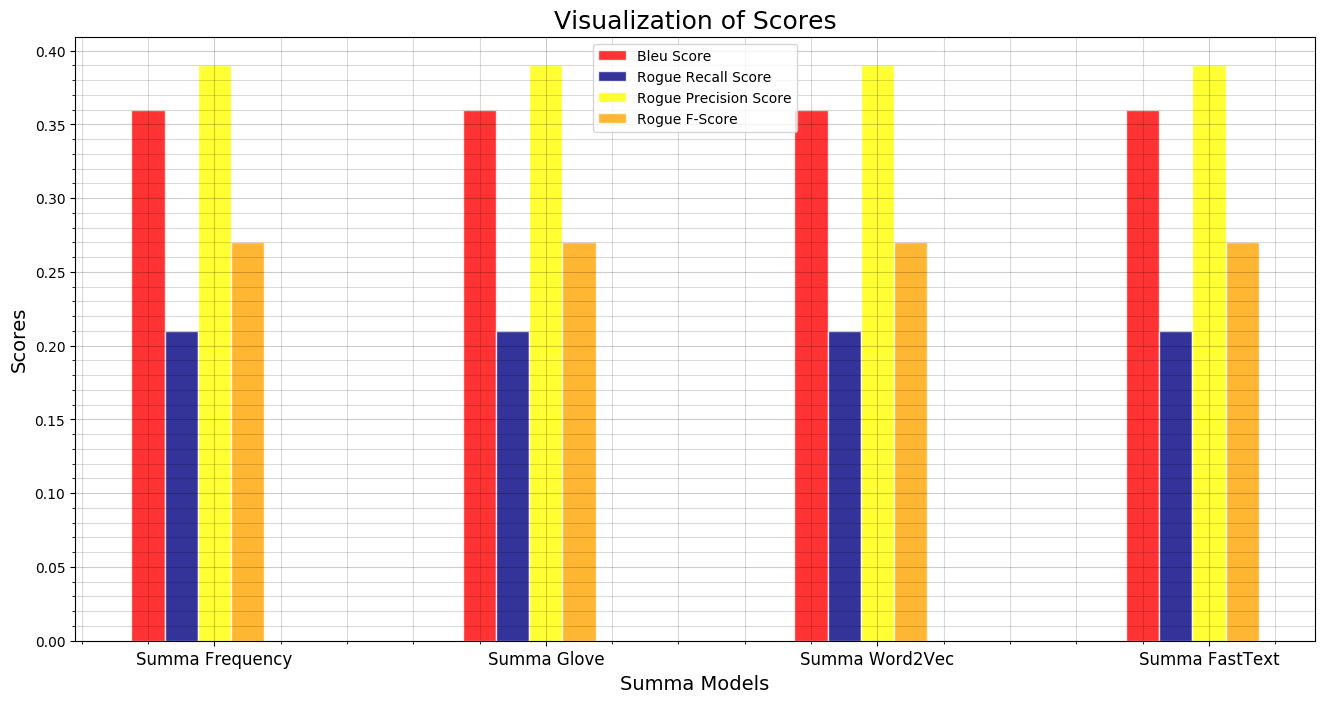


Most frequent words in this summary


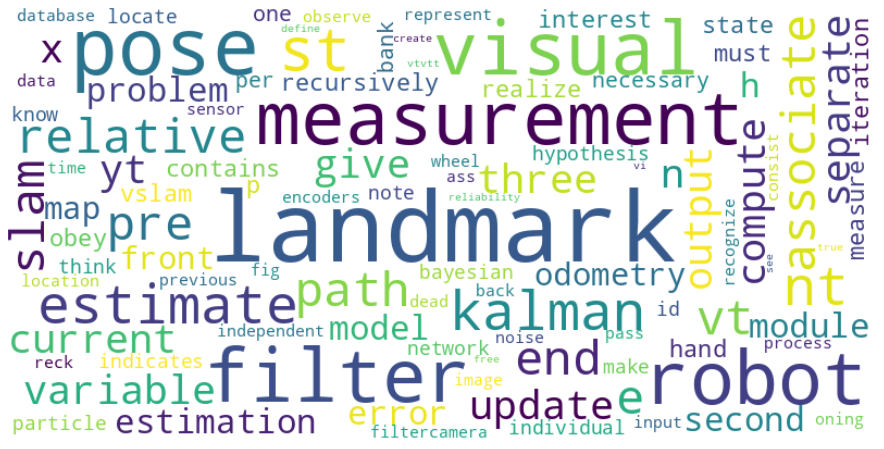

-------------------------------------------------------------------
SummaBot Glove 

However, for improved performance it is possible to process the measurements corresponding to one image simultaneously.
The output depends on whether 1) The front-end created a new landmark 2) The front-end computed a visual measurement 3) The front-end neither computed a visual measure- ment, nor created a landmark If a landmark was created, a landmark ID is provided to be used as a reference for future landmark recognitions.
For example, if the robot is operating in a highly populated environment, the field of view of the camera is frequently filled by non- stationary objects, such as moving people, that can not be used as reference points in a map.
Using the improved estimate of robot pose, the previously computed map is made better, and so forth.
Note that simply modifying the odometry noise model to accommodate for the large odometry error typically will not work if a particle filter is employed s

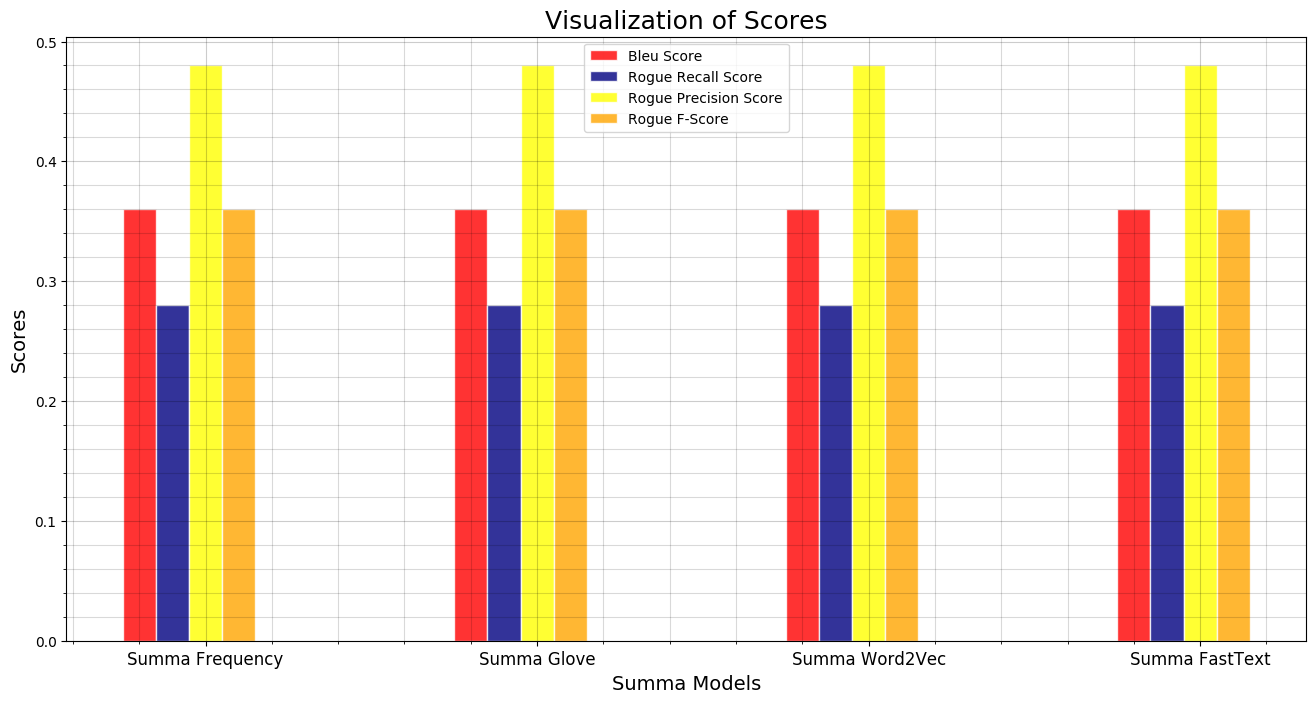


Most frequent words in this summary


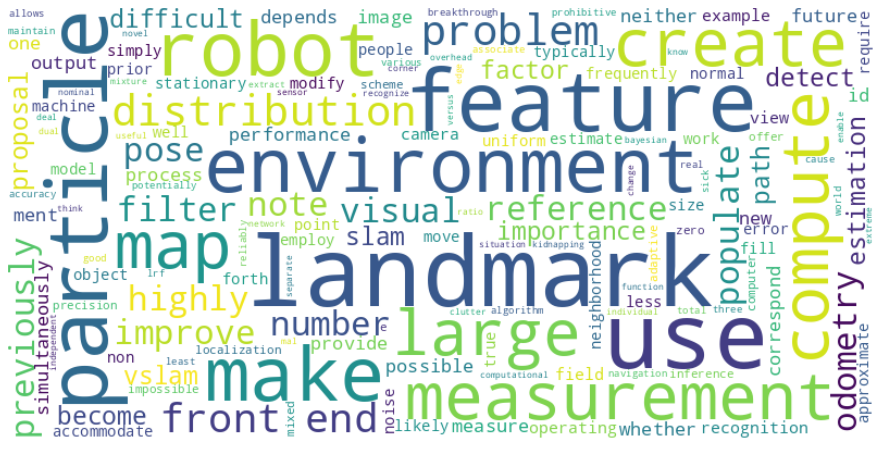

-------------------------------------------------------------------
SummaBot W2Vec 

By also using a localization scheme with a particle filter and an adaptive mixed proposal distribution , , vSLAM offers a breakthrough SLAM algorithm that allows navigation with good accuracy in various real-world environments.
The output depends on whether 1) The front-end created a new landmark 2) The front-end computed a visual measurement 3) The front-end neither computed a visual measure- ment, nor created a landmark If a landmark was created, a landmark ID is provided to be used as a reference for future landmark recognitions.
However, for improved performance it is possible to process the measurements corresponding to one image simultaneously.
However, there are at least three problems in using the SICK LRF: 1) It is difficult to reliably associate detected features with previously detected features; 2) the total number of features to maintain in a map is large, potentially causing a prohibitive

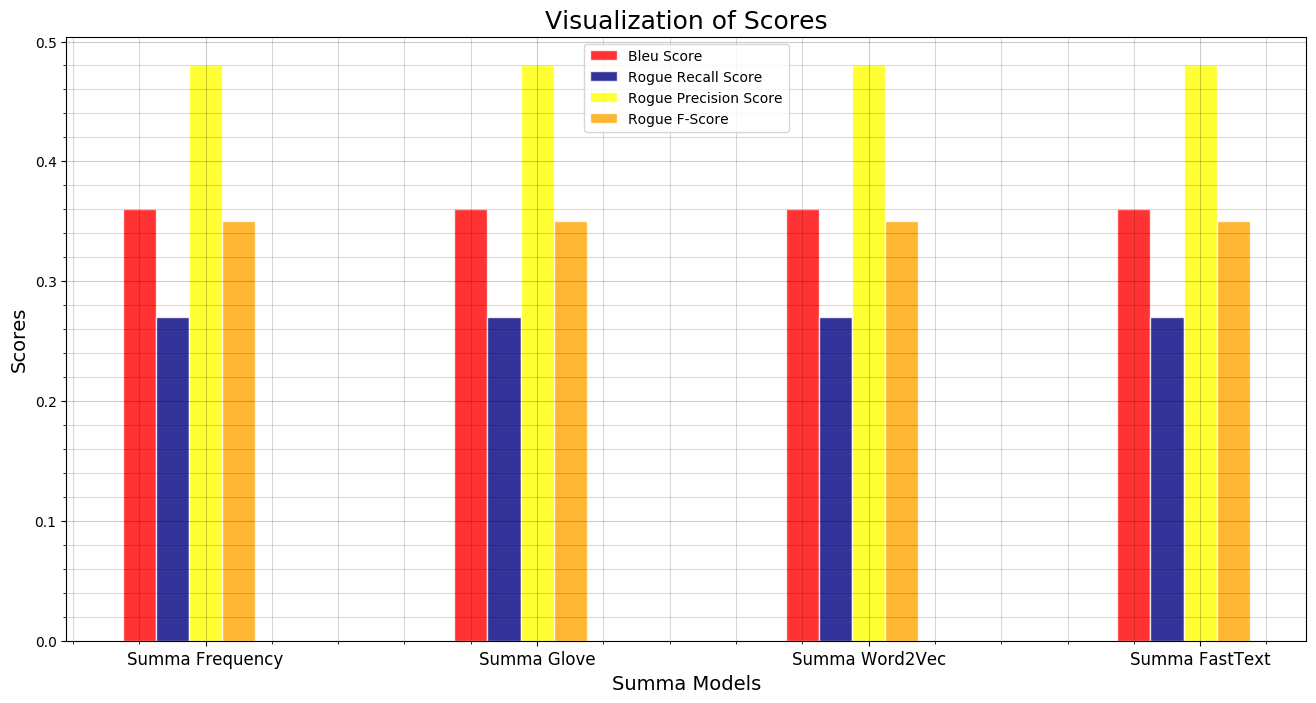


Most frequent words in this summary


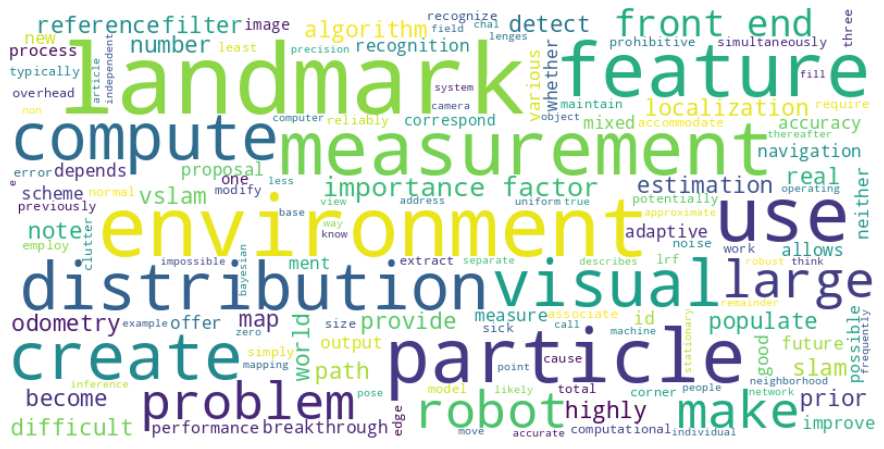

-------------------------------------------------------------------
SummaBot Fasttext 

The output depends on whether 1) The front-end created a new landmark 2) The front-end computed a visual measurement 3) The front-end neither computed a visual measure- ment, nor created a landmark If a landmark was created, a landmark ID is provided to be used as a reference for future landmark recognitions.
Also, if no prior particle is in some neighborhood of the true pose, then all importance factors are likely to become less than the machine precision of the computer; i.e., all importance factors will become zero making it impossible to make any inference from the measurements.
A very useful feature in vSLAM enabled by the novel use of the mixture proposal distribution, is that the ratio of nominal versus dual particles can be changed to deal with extreme situation, such as mal-functioning sensors, or kidnapping.
However, there are at least three problems in using the SICK LRF: 1) It is difficu

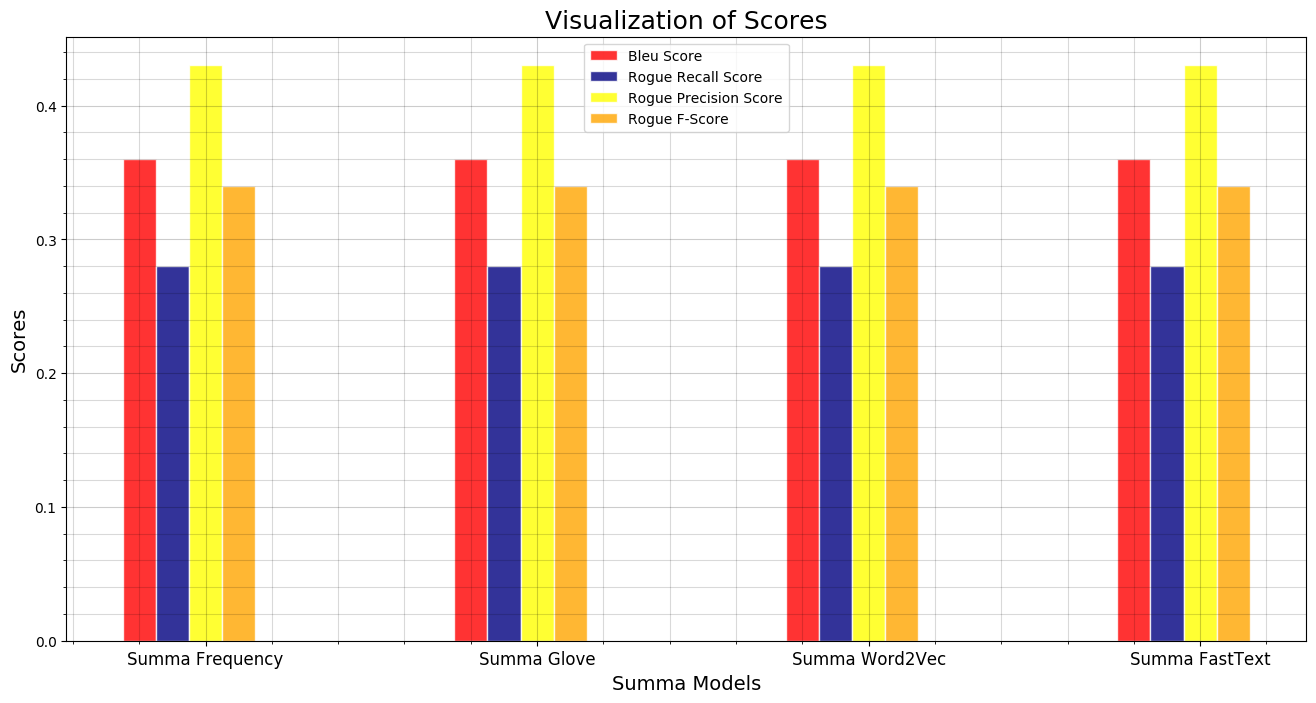


Most frequent words in this summary


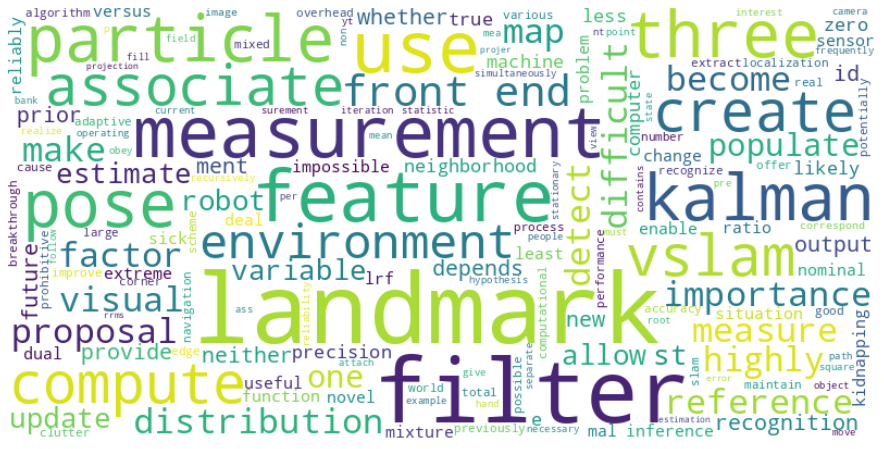

-------------------------------------------------------------------


In [27]:
SummaBotDriver('research_papers/06.pdf')

SummaBot Frequency 

The different settings are: Real-Only, in which the model is given only real data; Naı̈ve Mixing (Naı̈ve Mix): Simulated samples generated with no randomization are mixed with real-world samples such that half of each batch consists of simulated images; DBN Mixing & Randomization (Rand.
Their model’s first few layers are shared by two modules: the first predicts task-specific labels when provided with source data while the second is a separate domain classifier (a) Simulated World (b) Real World (c) Simulated Samples (d) Real Samples Fig.
5: The effect of using 8 million simulated samples of procedural objects with no randomization and various amounts of real data, for the best technique in each class.
In this work we examine for the first time how such a technique can be applied in situations where (a) no 3D models for the objects in the real-world are available and (b) the system is supposed to generalize to yet another set of previously unseen objects in the act

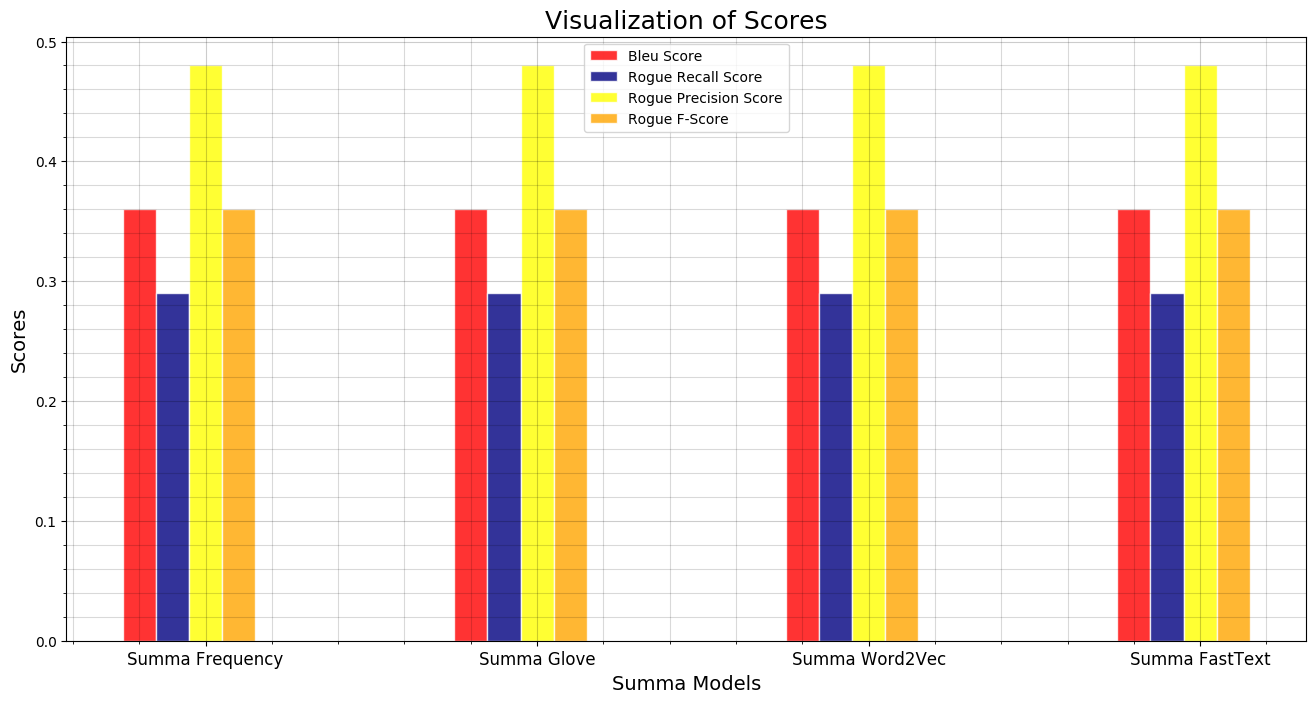


Most frequent words in this summary


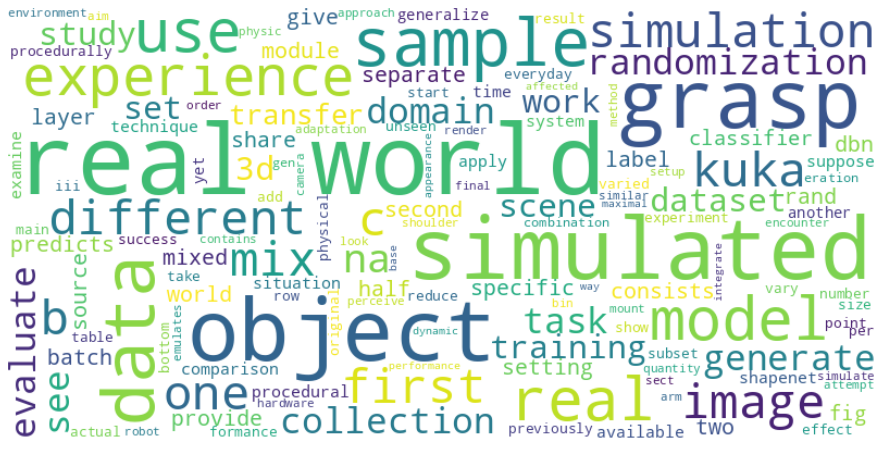

-------------------------------------------------------------------
SummaBot Glove 

However, we note the following: (a) our goal in this work is not to show that we can train the best possible grasping system, but that for the same amount of real-world data, the in- clusion of synthetic data can be helpful; we have relied on previous work for the grasping approach used; (b) our evaluation was conducted on a diverse and challenging range of objects, including transparent bottles, small round objects, deformable objects, and clutter; and (c) the method uses only monocular RGB images from an over-the-shoulder viewpoint, without depth or wrist-mounted cameras.
In this work we examine for the first time how such a technique can be applied in situations where (a) no 3D models for the objects in the real-world are available and (b) the system is supposed to generalize to yet another set of previously unseen objects in the actual real-world grasping task.
GraspGAN is able to close the gap for

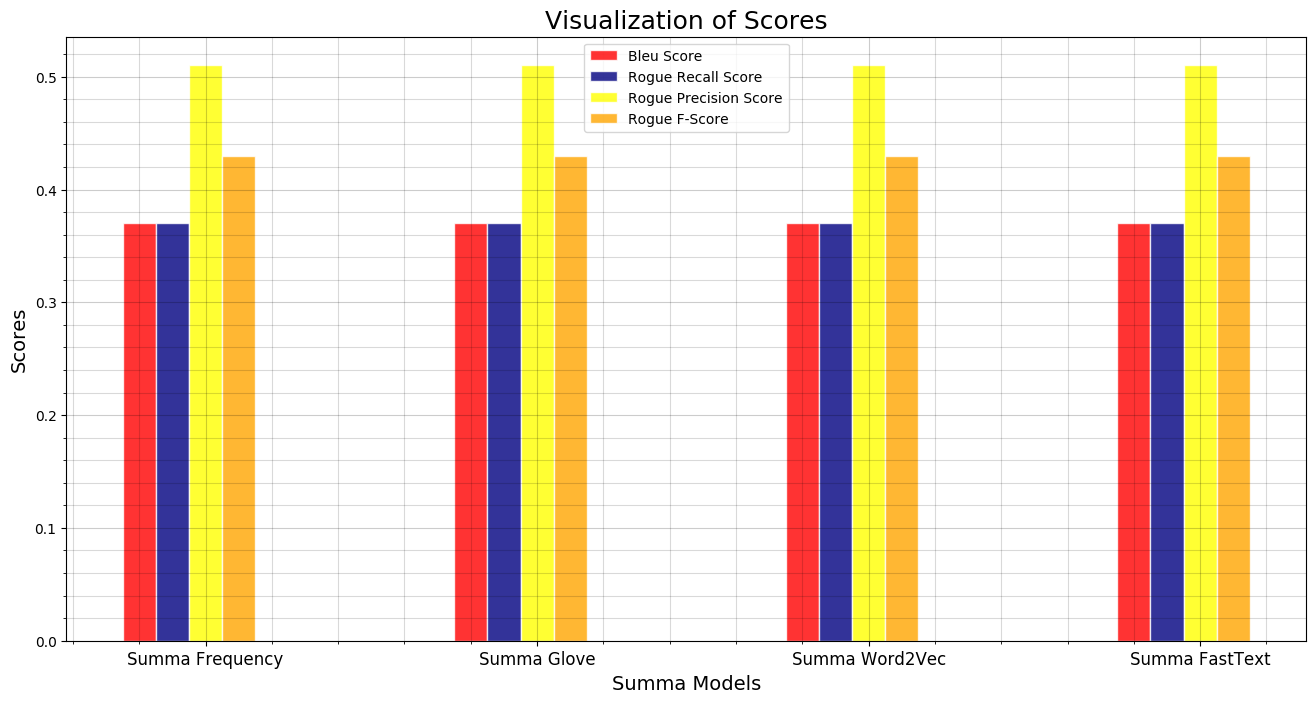


Most frequent words in this summary


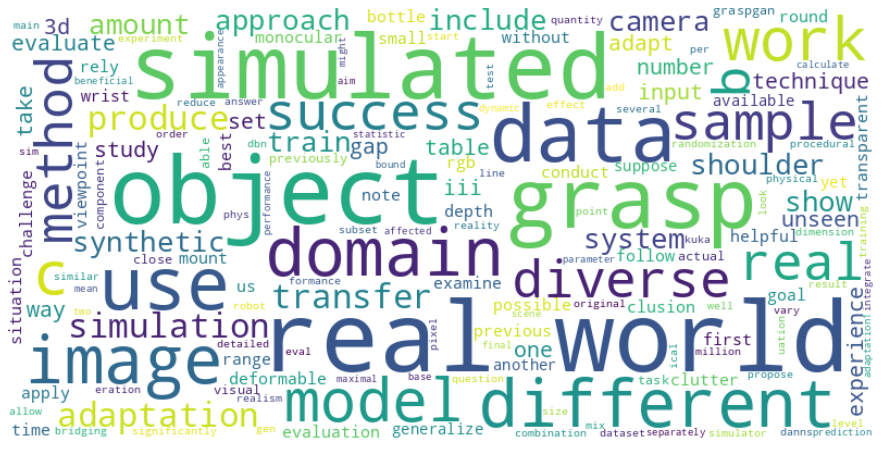

-------------------------------------------------------------------
SummaBot W2Vec 

However, we note the following: (a) our goal in this work is not to show that we can train the best possible grasping system, but that for the same amount of real-world data, the in- clusion of synthetic data can be helpful; we have relied on previous work for the grasping approach used; (b) our evaluation was conducted on a diverse and challenging range of objects, including transparent bottles, small round objects, deformable objects, and clutter; and (c) the method uses only monocular RGB images from an over-the-shoulder viewpoint, without depth or wrist-mounted cameras.
GraspGAN is able to close the gap for the visual component of the input significantly, allowing DANNs with DBN Mixing to better line up the TABLE III: Success of grasping 36 diverse and unseen phys- ical objects of all our methods trained on different amounts of real-world samples and 8 million simulated samples with procedural obje

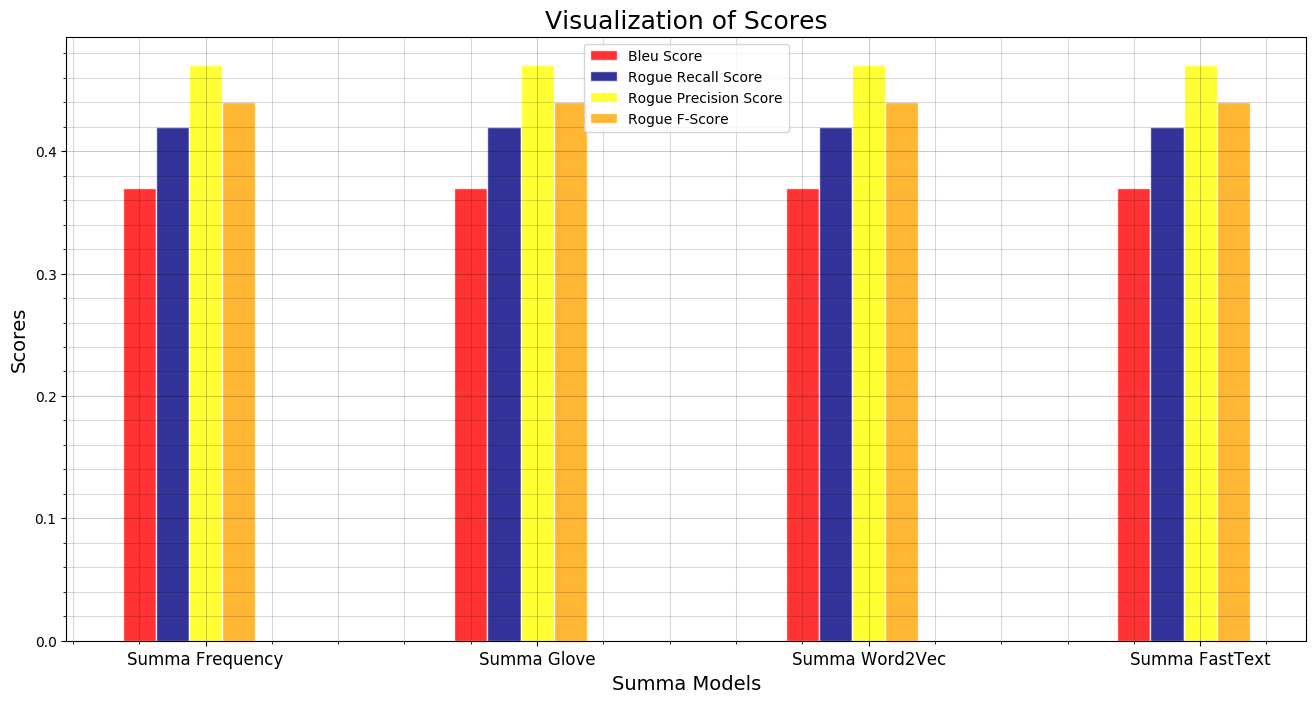


Most frequent words in this summary


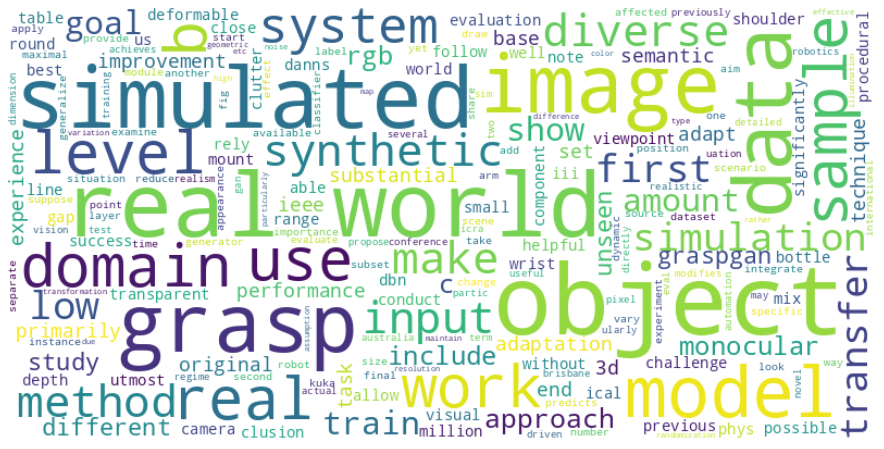

-------------------------------------------------------------------
SummaBot Fasttext 

However, we note the following: (a) our goal in this work is not to show that we can train the best possible grasping system, but that for the same amount of real-world data, the in- clusion of synthetic data can be helpful; we have relied on previous work for the grasping approach used; (b) our evaluation was conducted on a diverse and challenging range of objects, including transparent bottles, small round objects, deformable objects, and clutter; and (c) the method uses only monocular RGB images from an over-the-shoulder viewpoint, without depth or wrist-mounted cameras.
GraspGAN is able to close the gap for the visual component of the input significantly, allowing DANNs with DBN Mixing to better line up the TABLE III: Success of grasping 36 diverse and unseen phys- ical objects of all our methods trained on different amounts of real-world samples and 8 million simulated samples with procedural o

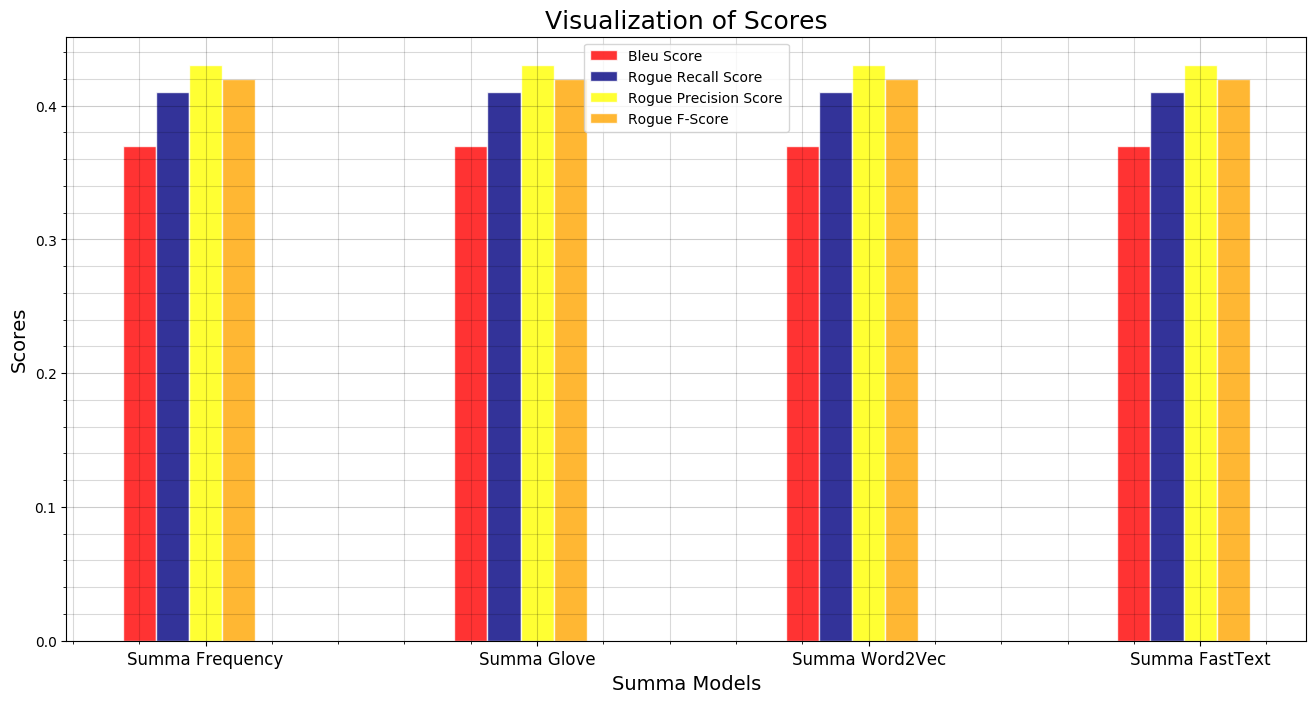


Most frequent words in this summary


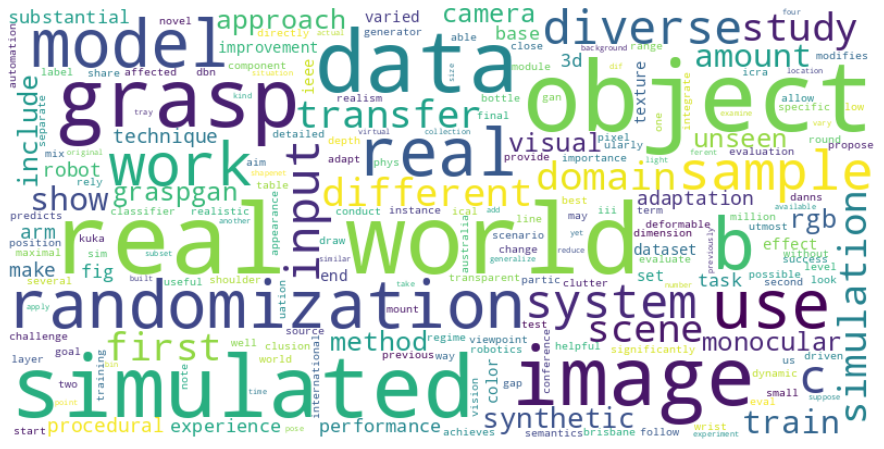

-------------------------------------------------------------------


In [28]:
SummaBotDriver('research_papers/02.pdf')

SummaBot Frequency 

Basically, we steer the simulator to generate a sequence of images similar to the images in the real-life dataset such that the steering angles generated by the simulator are also close to the steering angle labels in the real-life dataset.
Figure 7 shows, for each of our DNNs, Autumn and Chauf- feur, the distributions of the prediction error differences for the real datasets (subsequences) and the simulator-generated datasets For Autumn, the average prediction error difference for the real datasets and the simulator-generated datasets is 0.027.
Among these, we distinguish two high-level, distinct approaches to DNN testing: (1) Testing DNNs as stand-alone components, and (2) testing DNNs embedded into a specific application (e.g., an automated driving system) and in interaction with the application environment.
However, it does not change the fact that we have many scenarios for which offline and online testing results disagree, nor does it change the conclusion th

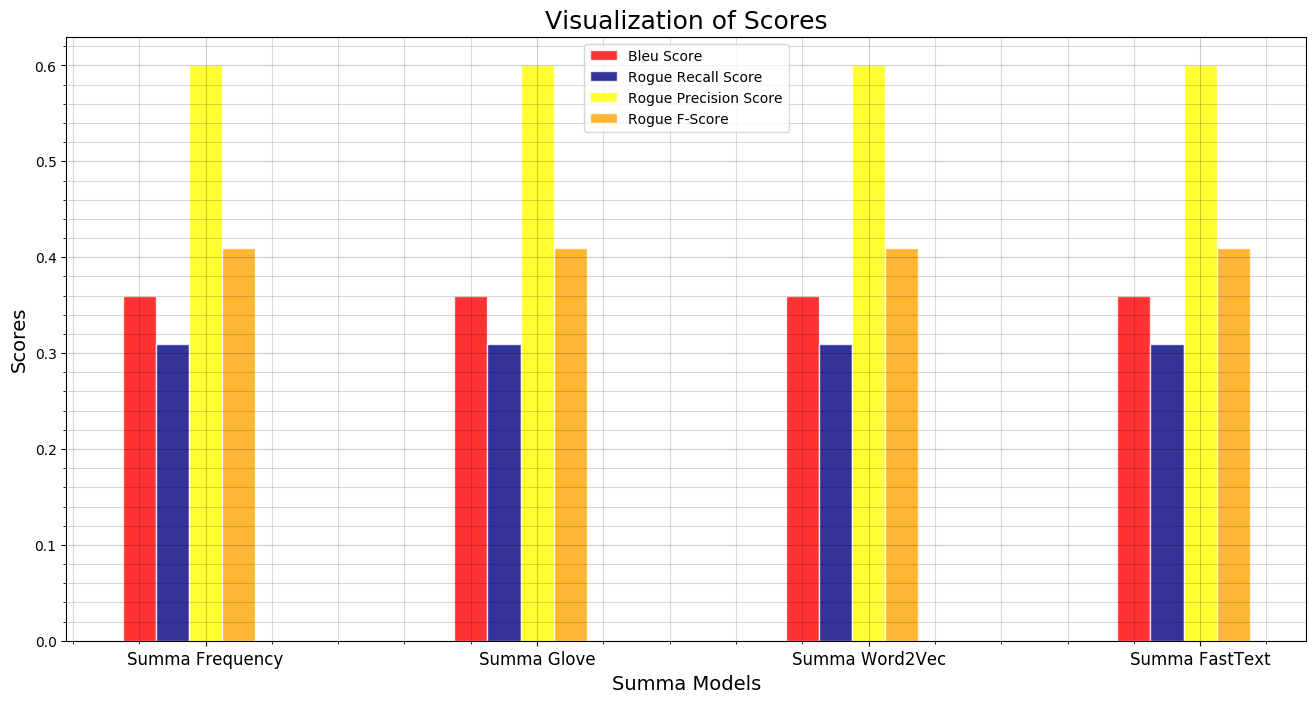


Most frequent words in this summary


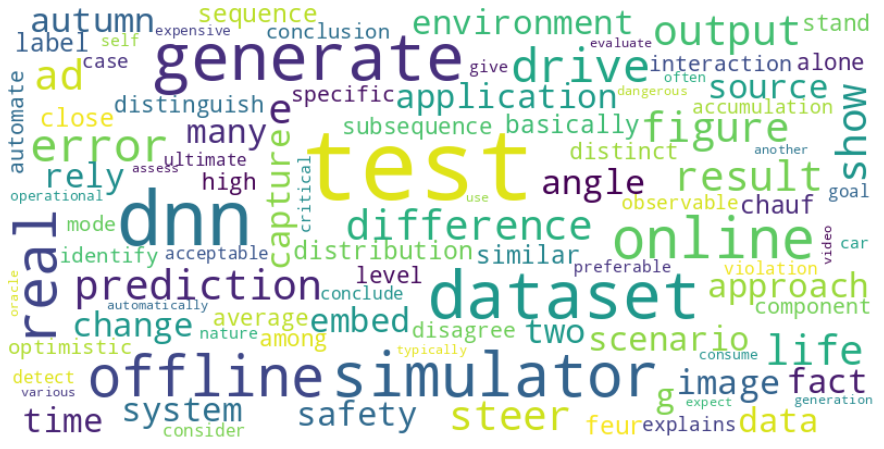

-------------------------------------------------------------------
SummaBot Glove 

The simulator generates for each of the mobile objects defined in a scenario, namely the ego vehicle and secondary vehicles and pedestrians, a vector of the trajectory TABLE I COMPARISON BETWEEN OFFLINE AND ONLINE TESTING Criterion Offline testing Online testing Definition Test DNNs using histor- ical data already gener- ated manually or auto- matically Test DNNs by embed- ding them into an appli- cation environment (vir- tual or real) Test mode Open-loop Closed-loop Test input Sequences of images from a camera (real-life) or a camera model (in a simulator) An initial configuration for a simulator to guide the simulator into gener- ating a specific driving scenario Test output Prediction error Safety violation Execution time Low High path of that object (i.e., a vector of values indicating the positions and speeds of the mobile object).
As shown in Figure 2, another source of test data generation for D

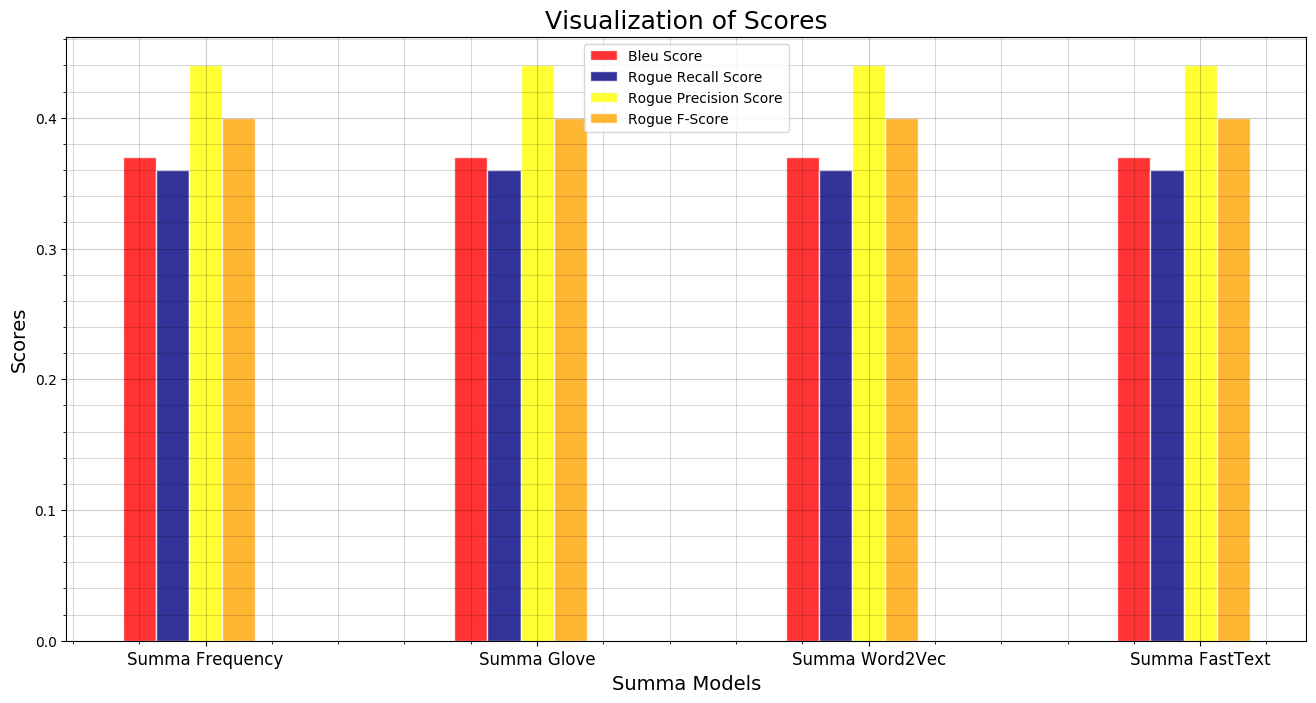


Most frequent words in this summary


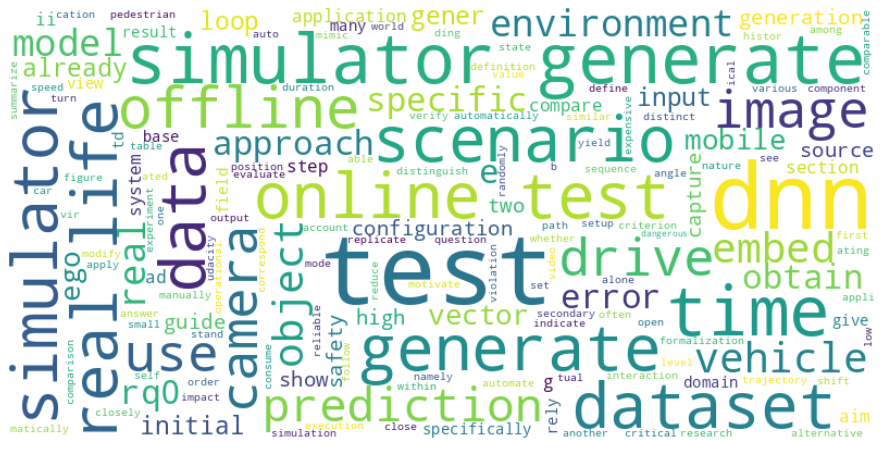

-------------------------------------------------------------------
SummaBot W2Vec 

The simulator generates for each of the mobile objects defined in a scenario, namely the ego vehicle and secondary vehicles and pedestrians, a vector of the trajectory TABLE I COMPARISON BETWEEN OFFLINE AND ONLINE TESTING Criterion Offline testing Online testing Definition Test DNNs using histor- ical data already gener- ated manually or auto- matically Test DNNs by embed- ding them into an appli- cation environment (vir- tual or real) Test mode Open-loop Closed-loop Test input Sequences of images from a camera (real-life) or a camera model (in a simulator) An initial configuration for a simulator to guide the simulator into gener- ating a specific driving scenario Test output Prediction error Safety violation Execution time Low High path of that object (i.e., a vector of values indicating the positions and speeds of the mobile object).
EXPERIMENTS We aim to compare offline and online testing of DNNs b

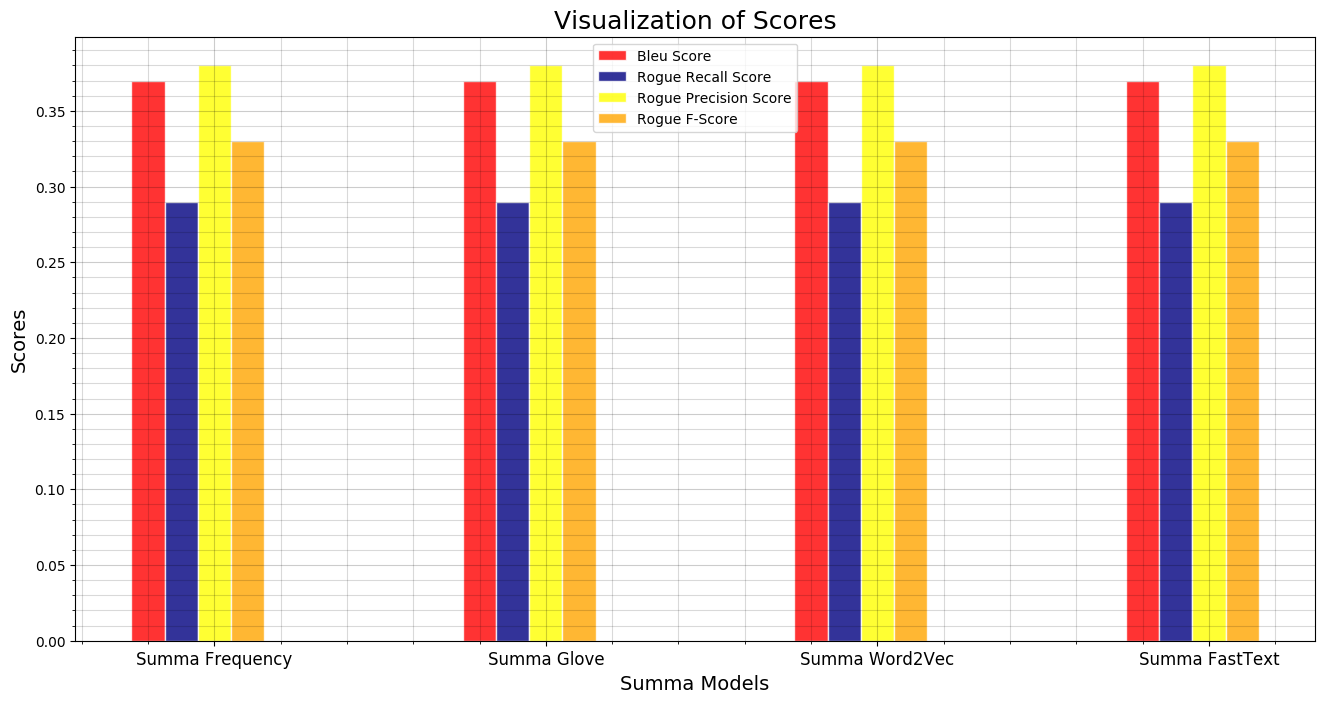


Most frequent words in this summary


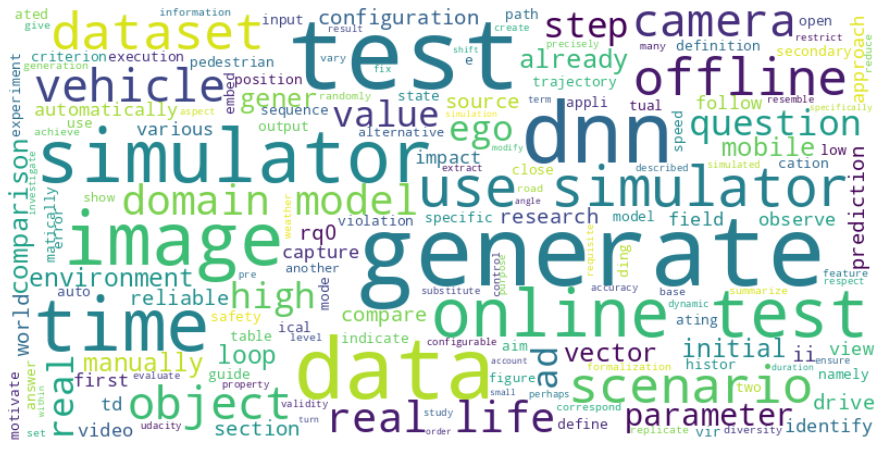

-------------------------------------------------------------------
SummaBot Fasttext 

The simulator generates for each of the mobile objects defined in a scenario, namely the ego vehicle and secondary vehicles and pedestrians, a vector of the trajectory TABLE I COMPARISON BETWEEN OFFLINE AND ONLINE TESTING Criterion Offline testing Online testing Definition Test DNNs using histor- ical data already gener- ated manually or auto- matically Test DNNs by embed- ding them into an appli- cation environment (vir- tual or real) Test mode Open-loop Closed-loop Test input Sequences of images from a camera (real-life) or a camera model (in a simulator) An initial configuration for a simulator to guide the simulator into gener- ating a specific driving scenario Test output Prediction error Safety violation Execution time Low High path of that object (i.e., a vector of values indicating the positions and speeds of the mobile object).
EXPERIMENTS We aim to compare offline and online testing of DNN

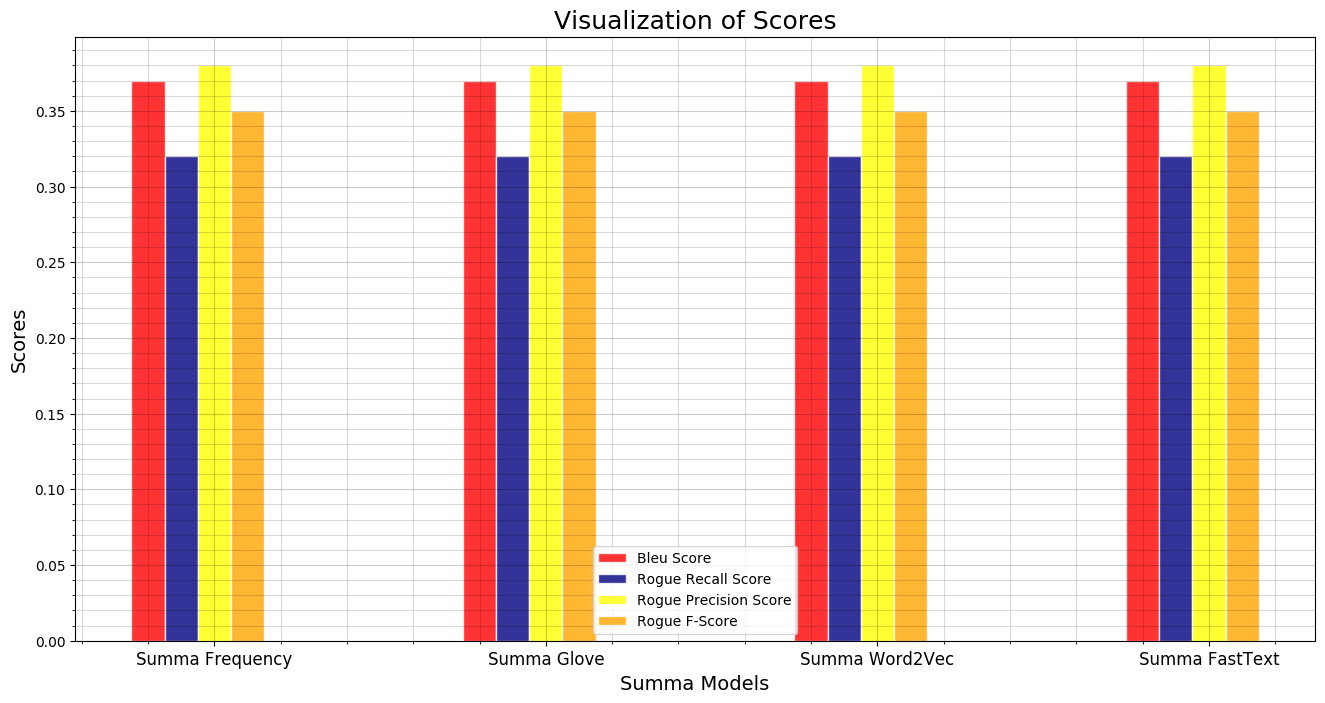


Most frequent words in this summary


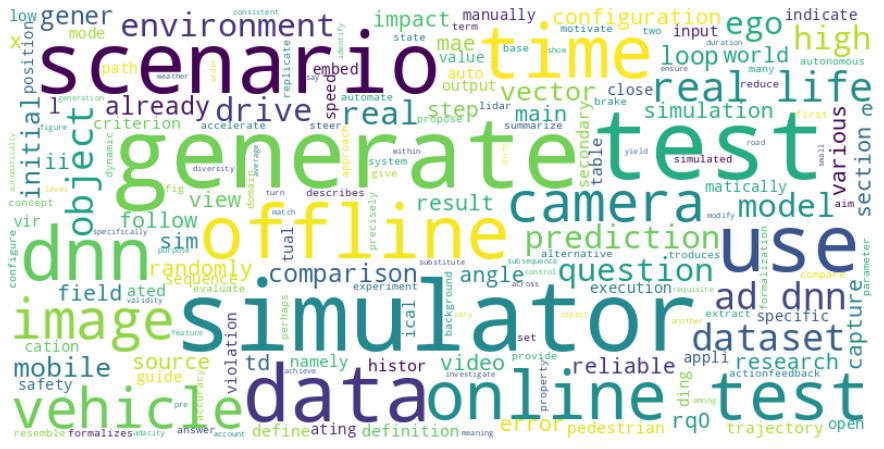

-------------------------------------------------------------------


In [29]:
SummaBotDriver('research_papers/03.pdf')

SummaBot Frequency 

Road Topology Generation The placement of roads in the simulation requires the road centers, the width of the road at each of those centers, the banking angles, and the details of the lanes.
As each road piece is generated, it is stitched to the previous piece by rotating it so that the tangent line along the first point is lined up with the tangent line of the last point of the previous piece and shifting it to that coordinate in the driving scenario.
The first value in the input defines what type of road piece will be created.
By limiting the roads to specific road pieces, the generated scenario can be constrained to realistic road networks and situations.
Example of Generated Four Way Intersection a) Placement of the roads: The positioning of each road is based on a center rectangle calculated to place all of the roads as close to the center as possible.
We define each of the roads connecting to the intersection as a multilane road with variable lanes and assume

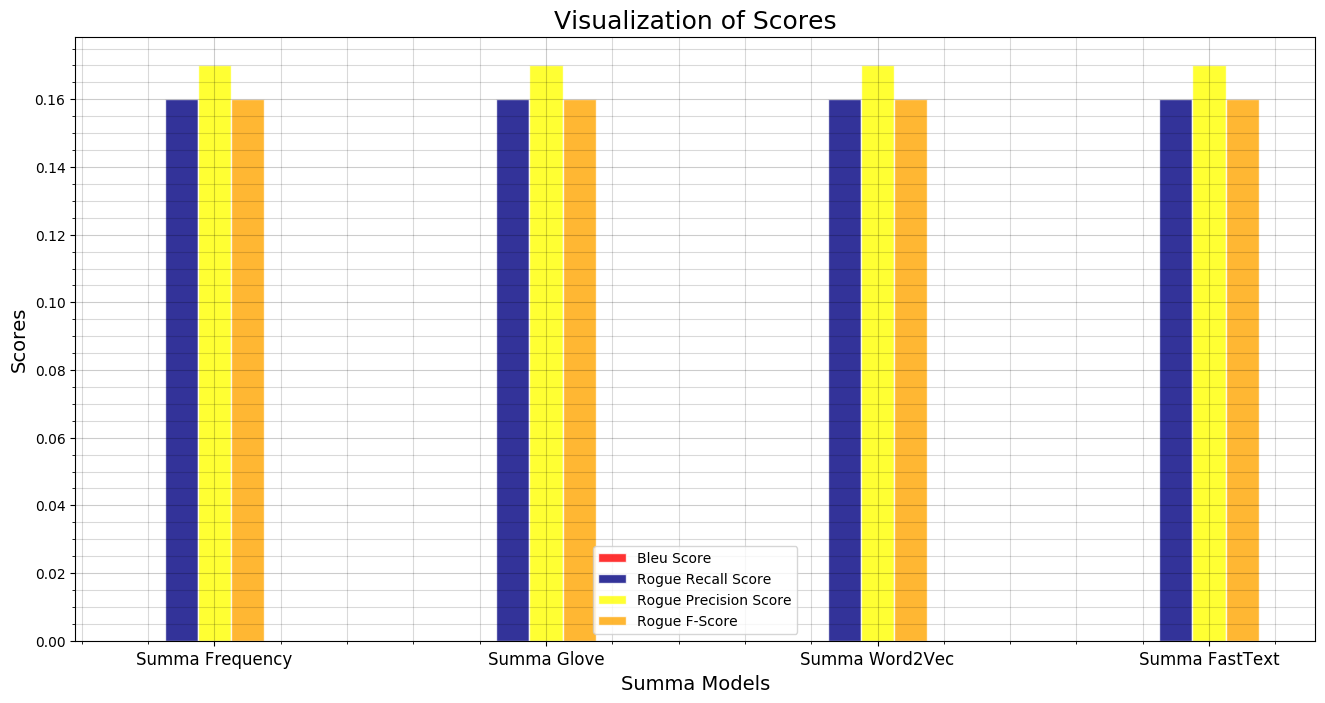


Most frequent words in this summary


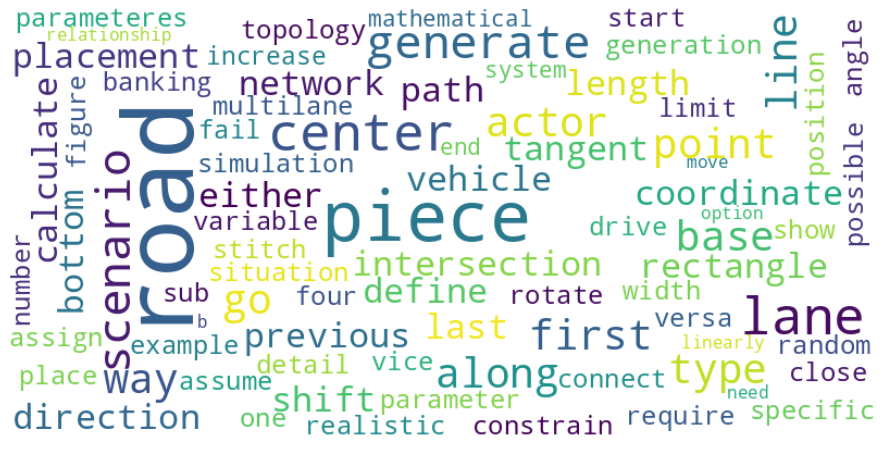

-------------------------------------------------------------------
SummaBot Glove 

• We propose a method to compose roadways in simulation with every possible combination of lines or curves, which is critical for enabling the modeling of real-life roads.
Then, generating the roads is a matter of taking an input and converting it into a series of points that the road follows within the context of the scene.
The first value in the input defines what type of road piece will be created.
In our implementation examples, the description of these lines as well as the four-way intersections have been demonstrated.
Because the number of points we chose to use to define this curve puts them extremely close together, this proved to be sufficient for connecting the pieces.
For instance, a road segment can be described by the function of the line that it follows as well as the width at each point.
The vehicles are assigned lane paths that were calculated as the roads were generated going in either

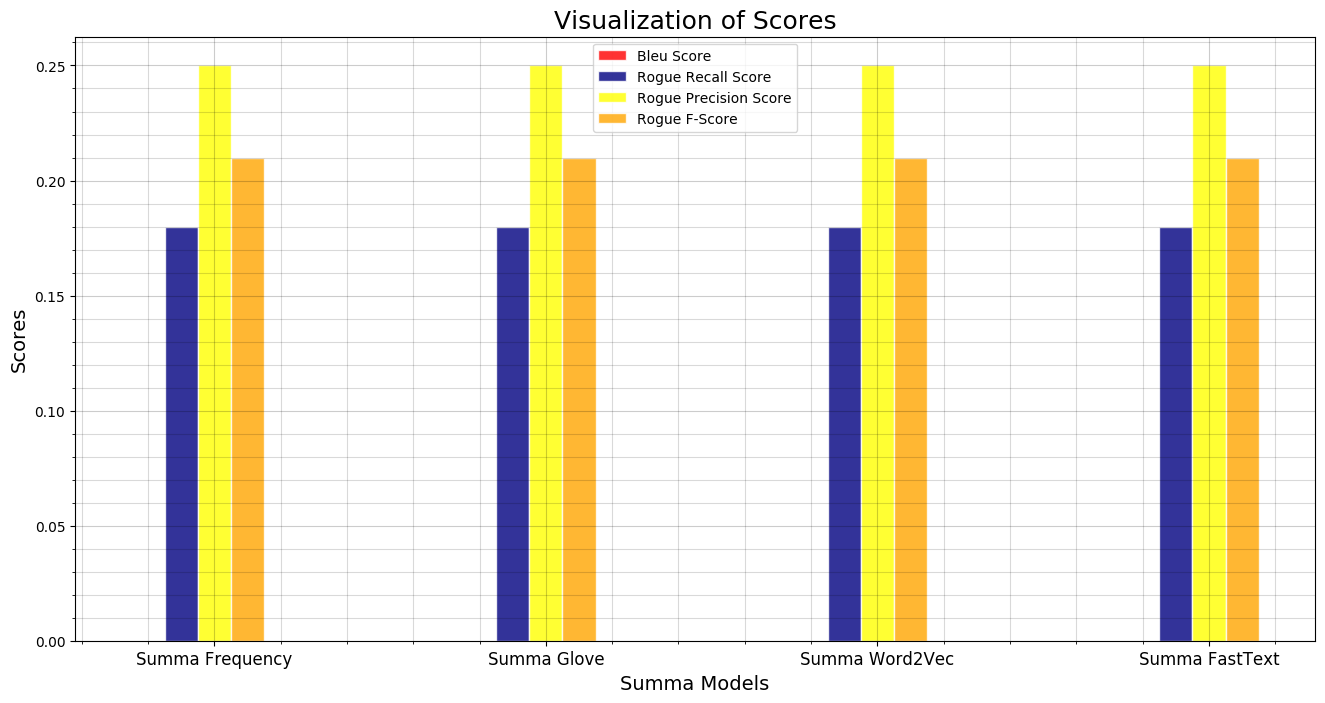


Most frequent words in this summary


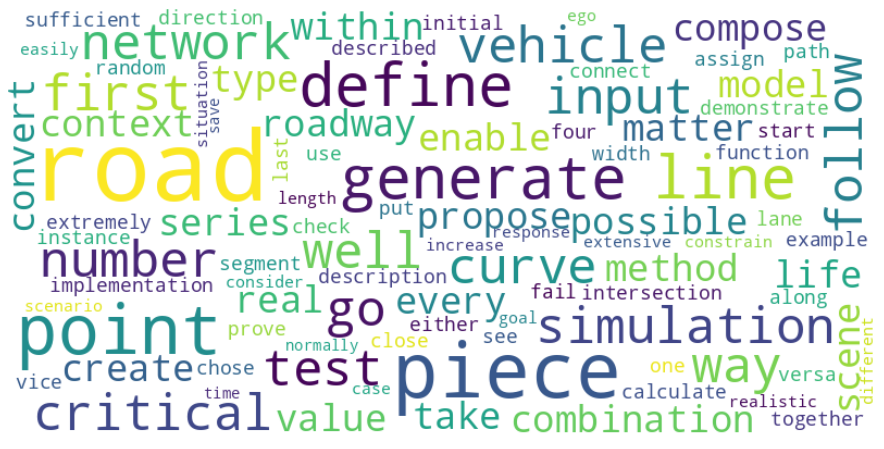

-------------------------------------------------------------------
SummaBot W2Vec 

• We propose a method to compose roadways in simulation with every possible combination of lines or curves, which is critical for enabling the modeling of real-life roads.
• We define a method to stitch road segments of different number of lanes to each other without errors in the simulation.978-1-7281-0137-8/19/$31.00 © 2019 IEEE • We propose a self verification method for each appended road segment within the proposed approach, which is critical for simulation efficiency.
Then, generating the roads is a matter of taking an input and converting it into a series of points that the road follows within the context of the scene.
The goal in defining different road pieces is to more easily constrain the generated scenario to realistic road networks and situations.
This example demonstrates the potential capabilities of the implementation methodology for practical testing pur- poses such as the combination 

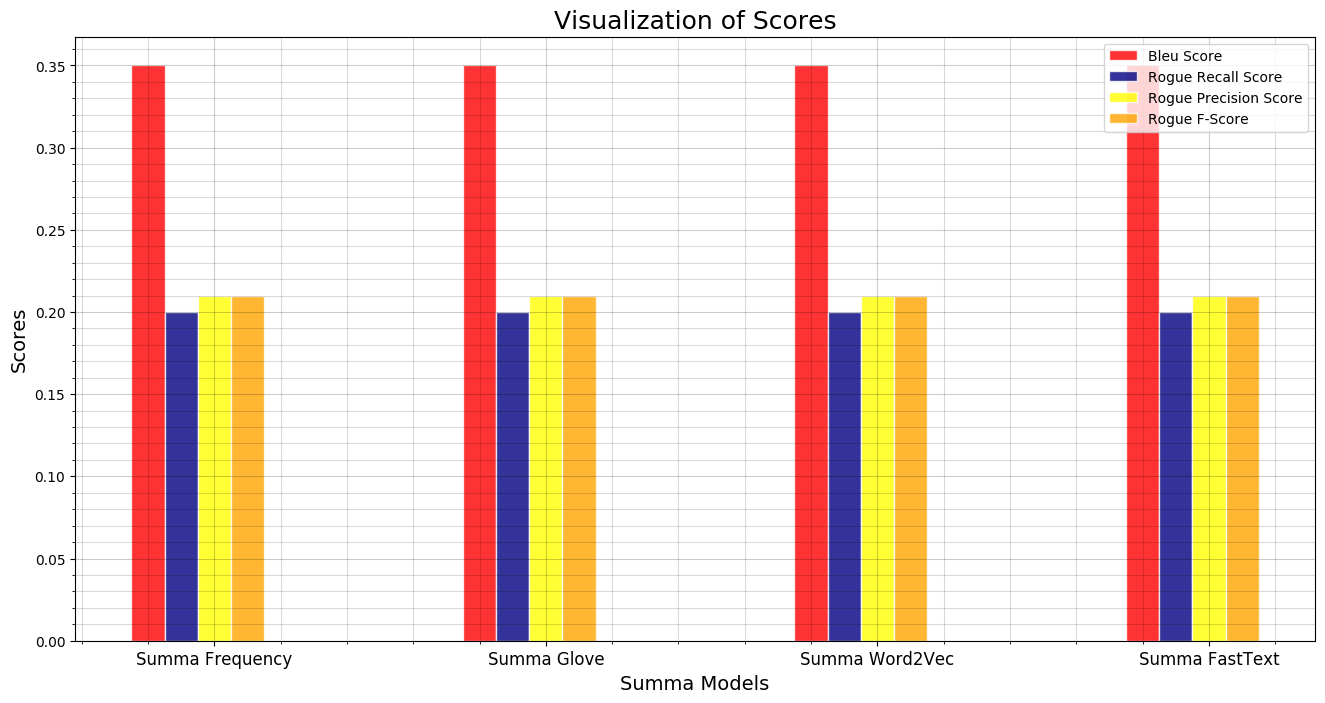


Most frequent words in this summary


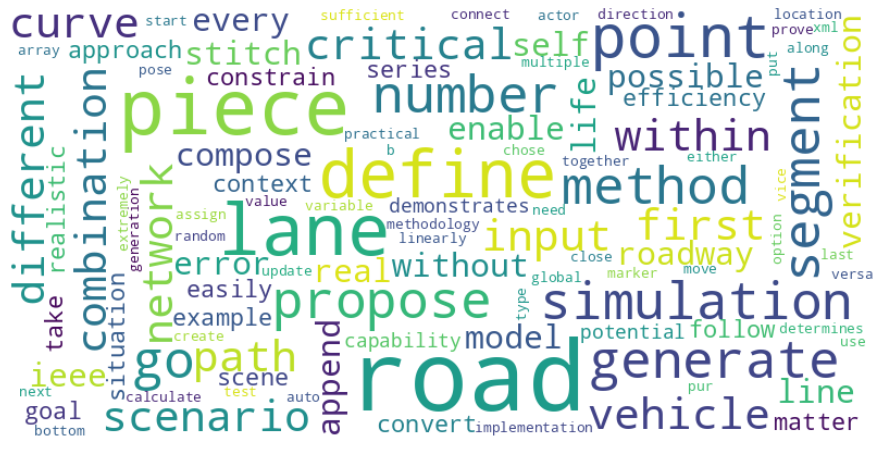

-------------------------------------------------------------------
SummaBot Fasttext 

• We propose a method to compose roadways in simulation with every possible combination of lines or curves, which is critical for enabling the modeling of real-life roads.
• We define a method to stitch road segments of different number of lanes to each other without errors in the simulation.978-1-7281-0137-8/19/$31.00 © 2019 IEEE • We propose a self verification method for each appended road segment within the proposed approach, which is critical for simulation efficiency.
Then, generating the roads is a matter of taking an input and converting it into a series of points that the road follows within the context of the scene.
This example demonstrates the potential capabilities of the implementation methodology for practical testing pur- poses such as the combination of road segments with variable number of lanes, multiple actors and lane markers.
The vehicles are assigned lane paths that were calcu

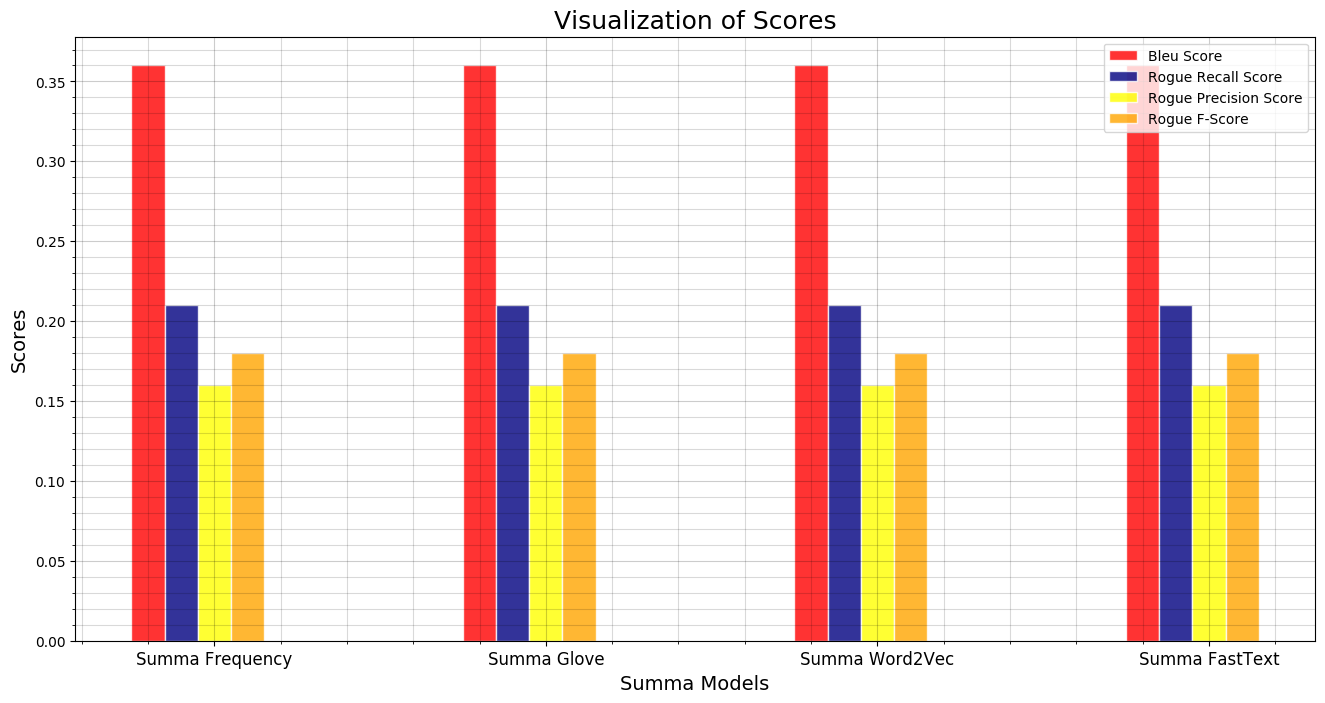


Most frequent words in this summary


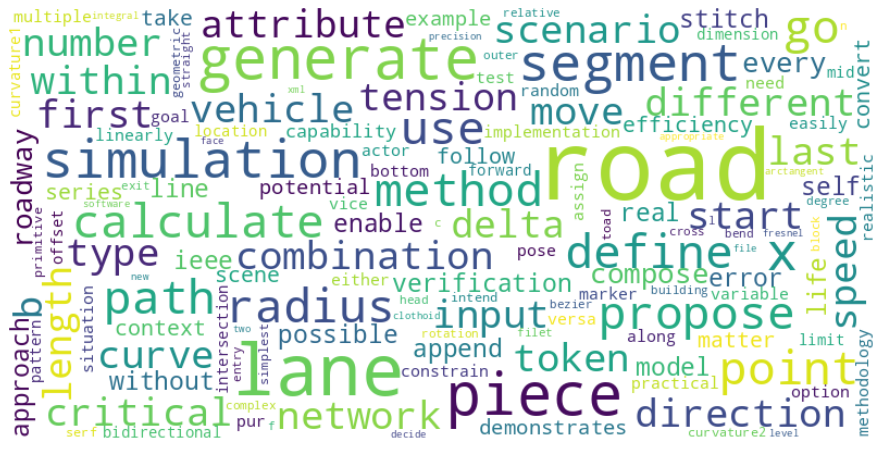

-------------------------------------------------------------------


In [30]:
SummaBotDriver('research_papers/01.pdf')